# Anomaly Detection in Timeseries: A Comprehensive Evaluation

Plots for our paper on TSAD.

In [1]:
# imports
import re
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 8)

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "benchmark-data" / "data-processed"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-11-17_runtime-benchmark-merged"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-11-02_runtime-benchmark'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/2021-11-01_runtime-gutentag-merged'),
 PosixPath('/home/projects/akita/results/2021-10-14_optim-extra'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-17_optim-extra2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/backup'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part6'),
 PosixPath('/home/projects/akita/results/202


Selecting:
Data path: /home/projects/akita/data/benchmark-data/data-processed
Result path: /home/projects/akita/results/2021-11-17_runtime-benchmark-merged


Load results and dataset metadata:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# aggregate runtime
df["overall_time"] = df["execute_main_time"].fillna(0) + df["train_main_time"].fillna(0)

# add RANGE_PR_AUC if it is not part of the results
if "RANGE_PR_AUC" not in df.columns:
    df["RANGE_PR_AUC"] = np.nan

# remove all duplicates (not necessary, but sometimes, we have some)
df = df.drop_duplicates()

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-11-17_runtime-benchmark-merged


Define utility functions

In [4]:
def load_scores_df(algorithm_name, dataset_id, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [5]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_id, use_plotly: bool = default_use_plotly, **kwargs):
    if not isinstance(algorithm_name, list):
        algorithms = [algorithm_name]
    else:
        algorithms = algorithm_name
    # deconstruct dataset ID
    collection_name, dataset_name = dataset_id

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[(df["collection"] == collection_name) & (df["dataset"] == dataset_name), "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo in algorithms:
        algos.append(algo)
        # get algorithm metric results
        try:
            auroc[algo] = df.loc[(df["algorithm"] == algo) & (df["collection"] == collection_name) & (df["dataset"] == dataset_name), "ROC_AUC"].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_id}.")
            auroc[algo] = -1
            skip_algos.append(algo)
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[algo] = load_scores_df(algo, dataset_id).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_id}.")
            df_scores[algo] = np.nan
            skip_algos.append(algo)
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=df_dataset.columns[i]), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for algo in algorithms:
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[algo], name=f"{algo}={auroc[algo]:.4f}"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique(algorithms))} on {dataset_id}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=df_dataset.columns[i])
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for algo in algorithms:
        axs[1].plot(df_scores.index, df_scores[algo], label=f"{algo}={auroc[algo]:.4f}")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique(algorithms))} on {dataset_id}")
    fig.tight_layout()
    plt.close()
    return fig

def plot_boxplot(df, n_show = 20, title="Box plots", ax_label="values", fmt_label=lambda x: x, fliers=False, use_plotly=default_use_plotly):
    n_show = n_show // 2
    title = title + f" (worst {n_show} and best {n_show} algorithms)"
    
    if use_plotly:
        import plotly.offline as py
        import plotly.graph_objects as go
        import plotly.figure_factory as ff
        import plotly.express as px
        from plotly.subplots import make_subplots
        
        fig = go.Figure()
        for i, c in enumerate(df.columns):
            fig.add_trace(go.Box(
                x=df[c],
                name=fmt_label(c),
                boxpoints=False,
                visible=None if i < n_show or i > len(df.columns)-n_show-1 else "legendonly"
            ))
        fig.update_layout(
            title={"text": title, "xanchor": "center", "x": 0.5},
            xaxis_title=ax_label,
            legend_title="Algorithms"
        )
        return py.iplot(fig)
    else:
        df_boxplot = pd.concat([df.iloc[:, :n_show], df.iloc[:, -n_show:]])
        labels = df_boxplot.columns
        labels = [fmt_label(c) for c in labels]
        values = [df_boxplot[c].dropna().values for c in df_boxplot.columns]
        fig = plt.figure()
        ax = fig.gca()
        ax.boxplot(values, sym=None if fliers else "", vert=True, meanline=True, showmeans=True, showfliers=fliers, manage_ticks=True)
        ax.set_ylabel(ax_label)
        ax.set_title(title)
        ax.set_xticklabels(labels, rotation=-45, ha="left", rotation_mode="anchor")
        # add vline to separate bad and good algos
        ymin, ymax = ax.get_ylim()
        ax.vlines([n_show + 0.5], ymin, ymax, colors="black", linestyles="dashed")
        fig.tight_layout()
        plt.close()
        return fig

def plot_algorithm_bars(df, y_name="ROC_AUC", title="Bar chart for algorithms", use_plotly=default_use_plotly):
    if use_plotly:
        fig = px.bar(df, x="algorithm", y=y_name)
        return py.iplot(fig)
    else:
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(df["algorithm"], df[y_name], label=y_name)
        ax.set_ylabel(y_name)
        ax.set_title(title)
        ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
        ax.legend()
        plt.close()
        return fig

## Analyze overall results on the GutenTAG datasets

### Overview

In [6]:
df[["algorithm", "collection", "dataset", "status", "ROC_AUC", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "execute_main_time", "hyper_params"]]

,algorithm,collection,dataset,status,ROC_AUC,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,execute_main_time,hyper_params
0,ARIMA,KDD-TSAD,001_UCR_Anomaly_DISTORTED1sddb40,Status.OK,0.162272,0.006566,0.004535,NaN,3345.032102,"{""differencing_degree"": 1, ""distance_metric"": ..."
1,ARIMA,KDD-TSAD,002_UCR_Anomaly_DISTORTED2sddb40,Status.OK,0.007541,0.002833,0.001890,NaN,5681.702504,"{""differencing_degree"": 1, ""distance_metric"": ..."
2,ARIMA,KDD-TSAD,003_UCR_Anomaly_DISTORTED3sddb40,Status.OK,0.998745,0.600000,0.700000,NaN,4180.894276,"{""differencing_degree"": 1, ""distance_metric"": ..."
3,ARIMA,KDD-TSAD,004_UCR_Anomaly_DISTORTEDBIDMC1,Status.OK,0.319475,0.041458,0.024029,NaN,789.318645,"{""differencing_degree"": 1, ""distance_metric"": ..."
4,ARIMA,KDD-TSAD,005_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature1,Status.OK,0.980997,0.005952,0.002976,NaN,1149.220772,"{""differencing_degree"": 1, ""distance_metric"": ..."
...,...,...,...,...,...,...,...,...,...,...
20162,normal,WebscopeS5,A4Benchmark-86,Status.OK,0.500000,0.009524,0.504762,NaN,0.000017,{}
20163,normal,Exathlon,5_1_100000_63-64,Status.OK,0.500000,0.126248,0.563124,NaN,0.000046,{}
20164,normal,Exathlon,5_1_100000_64-63,Status.OK,0.500000,0.062752,0.531376,NaN,0.000034,{}
20165,normal,Exathlon,1_2_100000_68-16,Status.OK,0.500000,0.788147,0.894074,NaN,0.000027,{}


### Algorithm problems grouped by algorithm training type

In [7]:
index_columns = ["algo_training_type", "algo_input_dimensionality", "algorithm"]
df_error_counts = df.pivot_table(index=index_columns, columns=["status"], values="repetition", aggfunc="count")
df_error_counts = df_error_counts.fillna(value=0).astype(np.int64)
df_error_counts = df_error_counts.reset_index().sort_values(by=["algo_input_dimensionality", "Status.ERROR"], ascending=False).set_index(index_columns)
df_error_counts["ALL"] = df_error_counts["Status.ERROR"] + df_error_counts["Status.OK"] + df_error_counts["Status.TIMEOUT"]

for tpe in ["SEMI_SUPERVISED", "SUPERVISED", "UNSUPERVISED"]:
    if tpe in df_error_counts.index:
        print(tpe)
        if default_use_plotly:
            py.iplot(ff.create_table(df_error_counts.loc[tpe], index=True))
        else:
            display(df_error_counts.loc[tpe])

SEMI_SUPERVISED


status                                                  Status.ERROR  \
algo_input_dimensionality algorithm                                    
UNIVARIATE                TARZAN                                  49   
                          OceanWNN                                26   
                          SR-CNN                                   6   
                          Bagel                                    5   
                          Donut                                    5   
                          ImageEmbeddingCAE                        5   
                          XGBoosting (RR)                          3   
                          Random Forest Regressor (RR)             0   
MULTIVARIATE              LSTM-AD                                157   
                          DeepAnT                                125   
                          EncDec-AD                               99   
                          OmniAnomaly                             22   
                          Hybrid KNN                              11   
                          Random Black Forest (RR)                 9   
                          LaserDBN                                 8   
                          HealthESN                                6   
                          TAnoGan                                  6   
                          Telemanom                                5   
                          RobustPCA                                0   

status                                                  Status.OK  \
algo_input_dimensionality algorithm                                 
UNIVARIATE                TARZAN                              210   
                          OceanWNN                            233   
                          SR-CNN                              157   
                          Bagel                               162   
                          Donut                               249   
                          ImageEmbeddingCAE                   254   
                          XGBoosting (RR)                     256   
                          Random Forest Regressor (RR)        204   
MULTIVARIATE              LSTM-AD                              48   
                          DeepAnT                             144   
                          EncDec-AD                            51   
                          OmniAnomaly                         247   
                          Hybrid KNN                          254   
                          Random Black Forest (RR)            238   
                          LaserDBN                            252   
                          HealthESN                            19   
                          TAnoGan                              73   
                          Telemanom                           263   
                          RobustPCA                           265   

status                                                  Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                          
UNIVARIATE                TARZAN                                     0  259  
                          OceanWNN                                   0  259  
                          SR-CNN                                    96  259  
                          Bagel                                     92  259  
                          Donut                                      5  259  
                          ImageEmbeddingCAE                          0  259  
                          XGBoosting (RR)                            0  259  
                          Random Forest Regressor (RR)              55  259  
MULTIVARIATE              LSTM-AD                                   64  269  
                          DeepAnT                                    0  269  
                          EncDec-AD                                119  269  
                       

SUPERVISED


status                                                   Status.ERROR  \
algo_input_dimensionality algorithm                                     
MULTIVARIATE              MultiHMM                                  5   
                          Hybrid Isolation Forest (HIF)             0   
                          Normalizing Flows                         0   

status                                                   Status.OK  \
algo_input_dimensionality algorithm                                  
MULTIVARIATE              MultiHMM                               1   
                          Hybrid Isolation Forest (HIF)          4   
                          Normalizing Flows                      1   

status                                                   Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                           
MULTIVARIATE              MultiHMM                                    0    6  
                          Hybrid Isolation Forest (HIF)               2    6  
                          Normalizing Flows                           5    6

UNSUPERVISED


status                                                     Status.ERROR  \
algo_input_dimensionality algorithm                                       
UNIVARIATE                SAND                                      132   
                          S-H-ESD (Twitter)                         115   
                          VALMOD                                    108   
                          Triple ES (Holt-Winter's)                  51   
                          PST                                        34   
                          NormA                                      25   
                          HOT SAX                                    19   
                          Series2Graph                               18   
                          Left STAMPi                                10   
                          ARIMA                                       2   
                          NumentaHTM                                  1   
                          PhaseSpace-SVM                              1   
                          DSPOT                                       0   
                          DWT-MLEAD                                   0   
                          FFT                                         0   
                          GrammarViz                                  0   
                          MedianMethod                                0   
                          PCI                                         0   
                          SSA                                         0   
                          STAMP                                       0   
                          STOMP                                       0   
                          Spectral Residual (SR)                      0   
                          Subsequence IF                              0   
                          Subsequence LOF                             0   
                          TSBitmap                                    0   
MULTIVARIATE              DBStream                                  309   
                          COF                                       221   
                          k-Means                                    49   
                          IF-LOF                                     10   
                          CBLOF                                       8   
                          Isolation Forest (iForest)                  6   
                          KNN                                         6   
                          LOF                                         6   
                          Torsk                                       6   
                          COPOD                                       5   
                          HBOS                                        5   
                          PCC                                         5   
                          Extended Isolation Forest (EIF)             1   
                          normal                                      0   

status                                                     Status.OK  \
algo_input_dimensionality algorithm                                    
UNIVARIATE                SAND                                   205   
                          S-H-ESD (Twitter)                      259   
                          VALMOD                                 254   
                          Triple ES (Holt-Winter's)              203   
                          PST                                    340   
                          NormA                                  295   
                          HOT SAX                                202   
                          Series2Graph                           356   
                          Left STAMPi                            345   
                          ARIMA                                  313   
                          NumentaHTM                        

### Summary

In [8]:
df_error_summary = pd.DataFrame(df_error_counts.sum(axis=0))
df_error_summary.columns = ["count"]
all_count = df_error_summary.loc["ALL", "count"]
df_error_summary["percentage"] = df_error_summary / all_count
df_error_summary.style.format({"percentage": "{:06.2%}".format})

,count,percentage
status,,
Status.ERROR,1705,08.45%
Status.OK,16752,83.07%
Status.TIMEOUT,1710,08.48%
ALL,20167,100.00%


#### Very slow algorithms

Algorithms, for which more than 20% of all executions ran into the timeout. You can adjust the timeout threshold.

In [9]:
timeout_threshold = 0.5
df_error_counts[df_error_counts["Status.TIMEOUT"] > timeout_threshold*df_error_counts["ALL"]].sort_index(level=[0, 1])

status                                                          Status.ERROR  \
algo_training_type algo_input_dimensionality algorithm                         
SEMI_SUPERVISED    MULTIVARIATE              HealthESN                     6   
                                             TAnoGan                       6   
SUPERVISED         MULTIVARIATE              Normalizing Flows             0   

status                                                          Status.OK  \
algo_training_type algo_input_dimensionality algorithm                      
SEMI_SUPERVISED    MULTIVARIATE              HealthESN                 19   
                                             TAnoGan                   73   
SUPERVISED         MULTIVARIATE              Normalizing Flows          1   

status                                                          Status.TIMEOUT  \
algo_training_type algo_input_dimensionality algorithm                           
SEMI_SUPERVISED    MULTIVARIATE              HealthESN                     244   
                                             TAnoGan                       190   
SUPERVISED         MULTIVARIATE              Normalizing Flows               5   

status                                                          ALL  
algo_training_type algo_input_dimensionality algorithm               
SEMI_SUPERVISED    MULTIVARIATE              HealthESN          269  
                                             TAnoGan            269  
SUPERVISED         MULTIVARIATE              Normalizing Flows    6

#### Broken algorithms

Algorithms, which failed for at least 20% of the executions. You can adjust the error threshold.

In [10]:
error_threshold = 0.5
df_error_counts[df_error_counts["Status.ERROR"] > error_threshold*df_error_counts["ALL"]].sort_index(level=[0, 1])

status                                                  Status.ERROR  \
algo_training_type algo_input_dimensionality algorithm                 
SEMI_SUPERVISED    MULTIVARIATE              LSTM-AD             157   
SUPERVISED         MULTIVARIATE              MultiHMM              5   
UNSUPERVISED       MULTIVARIATE              COF                 221   
                                             DBStream            309   

status                                                  Status.OK  \
algo_training_type algo_input_dimensionality algorithm              
SEMI_SUPERVISED    MULTIVARIATE              LSTM-AD           48   
SUPERVISED         MULTIVARIATE              MultiHMM           1   
UNSUPERVISED       MULTIVARIATE              COF              191   
                                             DBStream         103   

status                                                  Status.TIMEOUT  ALL  
algo_training_type algo_input_dimensionality algorithm                       
SEMI_SUPERVISED    MULTIVARIATE              LSTM-AD                64  269  
SUPERVISED         MULTIVARIATE              MultiHMM                0    6  
UNSUPERVISED       MULTIVARIATE              COF                     0  412  
                                             DBStream                0  412

Inspect errors of a specific algorithm:

In [11]:
ok = "- OK -"
oom = "- OOM -"
timeout = "- TIMEOUT -"
error_mapping = {
    "TimeoutError": timeout,
    "status code '137'": oom,
    "MemoryError: Unable to allocate": oom,
    "ValueError: Expected 2D array, got 1D array instead": "Wrong shape error",
    "could not broadcast input array from shape": "Wrong shape error",
    "not aligned": "Wrong shape error",  # shapes (20,) and (19,500) not aligned
    "array must not contain infs or NaNs": "unexpected Inf or NaN",
    "contains NaN": "unexpected Inf or NaN",
    "cannot convert float NaN to integer": "unexpected Inf or NaN",
    "Error(s) in loading state_dict": "Model loading error",
    "EOFError": "Model loading error",
    "Restoring from checkpoint failed": "Model loading error",
    "RecursionError: maximum recursion depth exceeded in comparison": "Max recursion depth exceeded",
    "but PCA is expecting": "BROKEN Exathlon DATASETS",  # ValueError: X has 44 features, but PCA is expecting 43 features as input.
    "input.size(-1) must be equal to input_size": "BROKEN Exathlon DATASETS",
    "ValueError: The condensed distance matrix must contain only finite values.": "LinAlgError",
    "LinAlgError": "LinAlgError",
    "NameError: name 'nan' is not defined": "Not converged",
    "Could not form valid cluster separation": "Not converged",
    "contamination must be in": "Invariance/assumption not met",
    "Data must not be constant": "Invariance/assumption not met",
    "Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data": "Invariance/assumption not met",
    "ValueError: Anom detection needs at least 2 periods worth of data": "Invariance/assumption not met",
    "`dataset` input should have multiple elements": "Invariance/assumption not met",
    "Cannot take a larger sample than population": "Invariance/assumption not met",
    "num_samples should be a positive integer value": "Invariance/assumption not met",
    "Cannot use heuristic method to compute initial seasonal and levels with less than periods + 10 datapoints": "Invariance/assumption not met",
    "ValueError: The window size must be less than or equal to 0": "Invariance/assumption not met",
    "The window size must be less than or equal to": "Incompatible parameters",
    "window_size has to be greater": "Incompatible parameters",
    "Set a higher piecewise_median_period_weeks": "Incompatible parameters",
    "OutOfBoundsDatetime: cannot convert input with unit 'm'": "Incompatible parameters",
    "`window_size` must be at least 4": "Incompatible parameters",
    "elements of 'k' must be between": "Incompatible parameters",
    "Expected n_neighbors <= n_samples": "Incompatible parameters",
    "PAA size can't be greater than the timeseries size": "Incompatible parameters",
    "All window sizes must be greater than or equal to": "Incompatible parameters",
    "ValueError: __len__() should return >= 0": "Bug",
    "stack expects a non-empty TensorList": "Bug",
    "expected non-empty vector": "Bug",
    "Found array with 0 feature(s)": "Bug",
    "ValueError: On entry to DLASCL parameter number 4 had an illegal value": "Bug",
    "Sample larger than population or is negative": "Bug",
    "ZeroDivisionError": "Bug",
    "IndexError": "Bug",
    "status code '139'": "Bug",
    "replacement has length zero": "Bug",
    "missing value where TRUE/FALSE needed": "Bug",
    "invalid subscript type 'list'": "Bug",
    "subscript out of bounds": "Bug",
    "invalid argument to unary operator": "Bug",
    "negative length vectors are not allowed": "Bug",
    "negative dimensions are not allowed": "Bug",
    "`std` must be positive": "Bug",
    "does not have key": "Bug",  # State '1' does not have key '1'
    "Less than 2 uniques breaks left": "Bug",
    "The encoder for value is invalid": "Bug",
    "arange: cannot compute length": "Bug",
    "n_components=3 must be between 0 and min(n_samples, n_features)": "Bug",
}

def get_folder(index):
    series = df.loc[index]
    path = (
        result_path /
        series["algorithm"] /
        series["hyper_params_id"] /
        series["collection"] /
        series["dataset"] /
        str(series["repetition"])
    )
    return path
    
def category_from_logfile(logfile):
    with logfile.open() as fh:
        log = fh.read()
    for error in error_mapping:
        if error in log:
            return error_mapping[error]
    #print(log)
    return "other"
    
def extract_category(series):
    status = series["status"]
    msg = series["error_message"]
    if status == "Status.OK":
        return ok
    elif status == "Status.TIMEOUT":
        return timeout
    # status is ERROR:
    elif "DockerAlgorithmFailedError" in msg:
        path = get_folder(series.name) / "execution.log"
        if path.exists():
            return category_from_logfile(path)
        return "DockerAlgorithmFailedError"
    else:
        m = re.search("^([\w]+)\(.*\)", msg)
        if m:
            error = m.group(1)
        else:
            error = msg
        return f"TimeEval:{error}"

df["error_category"] = df.apply(extract_category, axis="columns", raw=False)
df_error_category_overview = df.pivot_table(index="error_category", columns="algorithm", values="repetition", aggfunc="count")
df_error_category_overview.insert(0, "ALL (sum)", df_error_category_overview.sum(axis=1))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_error_category_overview.style.format("{:.0f}", na_rep=""))

algorithm,ALL (sum),ARIMA,Bagel,CBLOF,COF,COPOD,DBStream,DSPOT,DWT-MLEAD,DeepAnT,Donut,EncDec-AD,Extended Isolation Forest (EIF),FFT,GrammarViz,HBOS,HOT SAX,HealthESN,Hybrid Isolation Forest (HIF),Hybrid KNN,IF-LOF,ImageEmbeddingCAE,Isolation Forest (iForest),KNN,LOF,LSTM-AD,LaserDBN,Left STAMPi,MedianMethod,MultiHMM,NormA,Normalizing Flows,NumentaHTM,OceanWNN,OmniAnomaly,PCC,PCI,PST,PhaseSpace-SVM,Random Black Forest (RR),Random Forest Regressor (RR),RobustPCA,S-H-ESD (Twitter),SAND,SR-CNN,SSA,STAMP,STOMP,Series2Graph,Spectral Residual (SR),Subsequence IF,Subsequence LOF,TARZAN,TAnoGan,TSBitmap,Telemanom,Torsk,Triple ES (Holt-Winter's),VALMOD,XGBoosting (RR),k-Means,normal
error_category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
- OK -,16752,313,162,404,191,407,103,320,374,144,249,51,411,374,345,407,202,19,4,254,399,254,406,406,406,48,252,345,374,1,295,1,369,233,247,407,374,340,271,238,204,265,259,205,157,372,336,359,356,374,374,356,210,73,374,263,327,203,254,256,363,412
- OOM -,815,,,1,216,,10,,,116,3,87,1,,,,10,6,,5,1,,1,1,1,146,1,,,,13,,,,20,,,33,,9,,,,11,,,,,,,,,,4,,5,1,,70,3,40,
- TIMEOUT -,1710,59,92,,,,,54,,,5,119,,,29,,153,244,2,4,3,,,,,64,9,19,,,54,5,4,,,,,,102,22,55,4,,37,96,2,38,15,,,,18,,190,,1,79,120,12,,,
Bug,437,,5,,,,144,,,9,1,12,,,,,9,,,6,1,5,,,,11,7,,,,9,,1,25,,,,1,,,,,,111,,,,,15,,,,20,,,,1,,35,,9,
Incompatible parameters,269,,,,,,155,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,114,,,,,,,,,,,,,,,,,,,
Invariance/assumption not met,80,,,1,1,1,,,,,,,,,,1,,,,,,,1,1,1,,,10,,,,,,,,1,,,,,,,1,,6,,,,2,,,,,2,,,,51,,,,
LinAlgError,6,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,3,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,
Max recursion depth exceeded,29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,29,,,,,,,,,
Model loading error,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [12]:
error_category = "Incompatible parameters"
df_invalid_params = df[(df["error_category"] == error_category)].groupby(by="algorithm")[["repetition"]].count().sort_values("repetition", ascending=False)
print(f"{error_category} error algorithms:")
display(df_invalid_params.T)
print(f"{error_category} error datasets:")
df_broken_datasets = df[(df["error_category"] == error_category)].groupby(by="dataset")[["repetition"]].count().sort_values("repetition", ascending=False)
display(df_broken_datasets.T)

Incompatible parameters error algorithms:


algorithm,DBStream,S-H-ESD (Twitter)
repetition,155,114


Incompatible parameters error datasets:


dataset,ec2_cpu_utilization_53ea38,Twitter_volume_IBM,ec2_network_in_5abac7,A2Benchmark-73,ec2_disk_write_bytes_c0d644,A2Benchmark-77,ec2_cpu_utilization_fe7f93,A2Benchmark-82,ec2_cpu_utilization_825cc2,A4Benchmark-83,...,161_UCR_Anomaly_WalkingAceleration1,163_UCR_Anomaly_apneaecg2,164_UCR_Anomaly_apneaecg3,165_UCR_Anomaly_apneaecg4,166_UCR_Anomaly_apneaecg,173_UCR_Anomaly_insectEPG1,174_UCR_Anomaly_insectEPG2,175_UCR_Anomaly_insectEPG3,176_UCR_Anomaly_insectEPG4,speed_t4013
repetition,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


Fixed:

- [ ] DBStream (no idea how to fix it!)
- [x] S-H-ESD (Twitter)
- [x] Hybrid KNN
- [x] GrammarViz
- [x] Left STAMPi
- [x] STAMP
- [x] STOMP
- [x] PST

#### Comparison of errors to GutenTAG results

In [13]:
gutentag_result_path = Path("/home/projects/akita/results/2021-11-01_runtime-gutentag-merged")
# read and fill results
print(f"Reading results from {gutentag_result_path.resolve()}")
df_gutentag = pd.read_csv(gutentag_result_path.resolve() / "results.csv")
df_gutentag["dataset"] = df_gutentag["dataset"].str.split(".").str[0]
df_gutentag = df_gutentag.drop_duplicates()

def filter_groups(group):
    if len(group) > 1:
        group = group.sort_values(by="ROC_AUC", ascending=False)
    return group[:1]

df_grouped = df_gutentag.groupby(by=["algorithm", "collection", "dataset"])
df_grouped = df_grouped.apply(filter_groups)
df_gutentag = df_grouped.reset_index(drop=True)

# calculate error counts and percentage (relative errors)
df_gutentag = df_gutentag.pivot_table(index=["algorithm"], columns=["status"], values="repetition", aggfunc="count")
df_gutentag = df_gutentag.fillna(value=0).astype(np.int64)
#df_gutentag = df_gutentag.reset_index().sort_values(by=["Status.ERROR"], ascending=False).set_index("algorithm")
df_gutentag["ALL"] = df_gutentag["Status.ERROR"] + df_gutentag["Status.OK"] + df_gutentag["Status.TIMEOUT"]
df_gutentag["% ERROR"] = df_gutentag["Status.ERROR"] / df_gutentag["ALL"]
df_gutentag = df_gutentag.sort_values("% ERROR", ascending=False)
df_gutentag = df_gutentag[["Status.ERROR", "ALL", "% ERROR"]]

Reading results from /home/projects/akita/results/2021-11-01_runtime-gutentag-merged


In [14]:
# compare error counts to benchmark run
df_benchmark = df_error_counts.reset_index(["algo_training_type", "algo_input_dimensionality"], drop=True)[["Status.ERROR", "ALL"]].copy()
df_benchmark["% ERROR"] = df_benchmark["Status.ERROR"] / df_benchmark["ALL"].astype(np.float_)
df_benchmark = df_benchmark.sort_values("% ERROR", ascending=False)
df_benchmark

df_tmp = pd.merge(df_gutentag, df_benchmark, left_index=True, right_index=True, suffixes=("_gutentag", "_benchmark"), how="outer")
df_tmp["change in relative error"] = df_tmp["% ERROR_benchmark"] - df_tmp["% ERROR_gutentag"]
df_tmp = df_tmp.sort_values("change in relative error", ascending=False)
df_tmp.style.format({"% ERROR_gutentag": "{:06.2%}".format, "% ERROR_benchmark": "{:06.2%}".format, "change in relative error": "{:+05.2f}".format})

status,Status.ERROR_gutentag,ALL_gutentag,% ERROR_gutentag,Status.ERROR_benchmark,ALL_benchmark,% ERROR_benchmark,change in relative error
algorithm,,,,,,,
COF,0.000000,193.000000,00.00%,221,412,53.64%,+0.54
DeepAnT,10.000000,193.000000,05.18%,125,269,46.47%,+0.41
MultiHMM,98.000000,193.000000,50.78%,5,6,83.33%,+0.33
S-H-ESD (Twitter),0.000000,168.000000,00.00%,115,374,30.75%,+0.31
VALMOD,8.000000,168.000000,04.76%,108,374,28.88%,+0.24
SAND,28.000000,168.000000,16.67%,132,374,35.29%,+0.19
EncDec-AD,39.000000,193.000000,20.21%,99,269,36.80%,+0.17
Triple ES (Holt-Winter's),0.000000,168.000000,00.00%,51,374,13.64%,+0.14
k-Means,0.000000,193.000000,00.00%,49,412,11.89%,+0.12


/tmp/ipykernel_5881/202798847.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


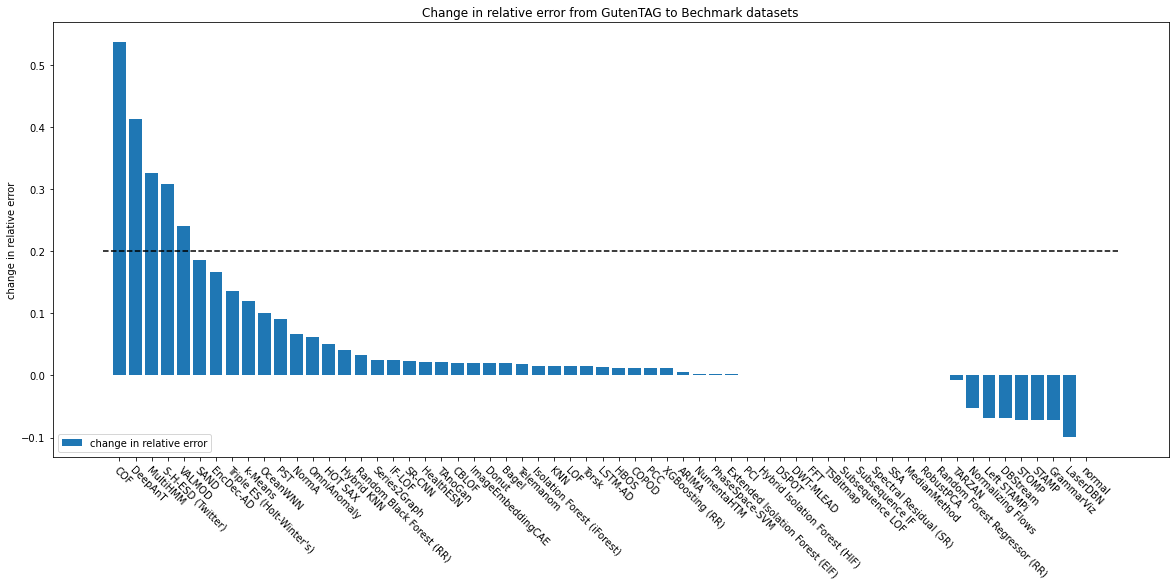

In [15]:
fig = plot_algorithm_bars(df_tmp.reset_index(drop=False), y_name="change in relative error", title="Change in relative error from GutenTAG to Bechmark datasets")
ax = fig.gca()
ax.hlines([0.2], -1, len(df_tmp)+1, color="black", linestyle="dashed")
fig

- **COF** --> OOMs
- **Hybrid KNN** --> incompatible params, is to be re-executed
- **VALMOD** --> 27 bugs, >90 `KilledWorker`-exceptions that are re-executed
- **DeepAnT** --> OOMs
- **S-H-ESD** --> imcompatible params, is to be re-executed
- **TSBitmap** --> `KilledWorker`-exceptions that are re-executed
- **Triple ES** --> invariances not met and `KilledWorker`-exceptions that are re-executed
- **HIF** --> 2/6 bugs instead of 0/193; Exathlong-datasets! Those are re-executed!
- **MultiHMM** --> 5/6 not converged; no idea on how to fix this!
- **Torsk** --> `KilledWorker`-exceptions that are re-executed
- **SAND** --> a lot of bugs and shape error <-- **send errors to Paul**
- **STAMP** --> incompatible params and `KilledWorker`-exceptions, is to be re-executed
- **STOMP** --> incompatible params and `KilledWorker`-exceptions, is to be re-executed

#### Compile list of to-be-re-executed experiments

We should re-execute all experiments that

- used the Exathlon datasets
- had wrong parameter settings (see above)
- include the normal baseline
- had `KilledWorker`-exceptions
- used the Genesis dataset

In [16]:
fixed_algos = ["S-H-ESD (Twitter)", "Hybrid KNN", "GrammarViz", "Left STAMPi", "STAMP", "STOMP", "PST"]
df_tmp = df.copy()
df_tmp = df_tmp[
    (df_tmp["collection"] == "Exathlon") |
    ((df_tmp["collection"] == "Genesis") & (df_tmp["status"] != "Status.TIMEOUT")) |
    ((df_tmp["algorithm"].isin(fixed_algos)) & (df_tmp["error_category"] == "Incompatible parameters")) |
    (df_tmp["algorithm"] == "normal") |
    (df_tmp["error_category"] == "TimeEval:KilledWorker")
]
df_tmp = df_tmp[["algorithm", "collection", "dataset", "hyper_params_id"]]
#df_tmp.to_csv(result_root_path / "re-execution-experiments.csv", index=False, header=True)
df_tmp

,algorithm,collection,dataset,hyper_params_id
896,CBLOF,Genesis,genesis-anomalies,4af4d919471b6491e8bdcca811a5e413
1041,CBLOF,Exathlon,5_1_100000_63-64,4af4d919471b6491e8bdcca811a5e413
1042,CBLOF,Exathlon,5_1_100000_64-63,4af4d919471b6491e8bdcca811a5e413
1043,CBLOF,Exathlon,1_2_100000_68-16,4af4d919471b6491e8bdcca811a5e413
1044,CBLOF,Exathlon,4_1_100000_61-29,4af4d919471b6491e8bdcca811a5e413
...,...,...,...,...
20162,normal,WebscopeS5,A4Benchmark-86,d751713988987e9331980363e24189ce
20163,normal,Exathlon,5_1_100000_63-64,d751713988987e9331980363e24189ce
20164,normal,Exathlon,5_1_100000_64-63,d751713988987e9331980363e24189ce
20165,normal,Exathlon,1_2_100000_68-16,d751713988987e9331980363e24189ce


### Algorithm quality assessment based on ROC_AUC

In [17]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df.pivot_table(index=["algo_input_dimensionality", "algo_training_type", "algorithm"], columns="collection", values=["PR_AUC"], aggfunc="mean").style.format("{:5.2f}", na_rep=""))

In [18]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_scores = df.pivot_table(index="algorithm", values="ROC_AUC", aggfunc=aggregations)
df_overall_scores.columns = aggregations
df_overall_scores = df_overall_scores.sort_values(by=dominant_aggregation, ascending=False)


df_asl = df.pivot(index="algorithm", columns=["collection", "dataset"], values="ROC_AUC")
df_asl = df_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl[dominant_aggregation] = df_asl.agg(dominant_aggregation, axis=1)
df_asl = df_asl.sort_values(by=dominant_aggregation, ascending=True)
df_asl = df_asl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_scores.T)

/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


algorithm,Normalizing Flows,GrammarViz,Hybrid Isolation Forest (HIF),Subsequence LOF,Left STAMPi,SAND,Donut,VALMOD,NormA,STOMP,k-Means,STAMP,DWT-MLEAD,Random Forest Regressor (RR),LSTM-AD,Series2Graph,Telemanom,HealthESN,XGBoosting (RR),Torsk,Random Black Forest (RR),Subsequence IF,ImageEmbeddingCAE,HOT SAX,DeepAnT,EncDec-AD,OceanWNN,Triple ES (Holt-Winter's),KNN,ARIMA,Isolation Forest (iForest),Extended Isolation Forest (EIF),HBOS,COPOD,LOF,NumentaHTM,PhaseSpace-SVM,CBLOF,IF-LOF,COF,PCI,OmniAnomaly,MedianMethod,DBStream,TSBitmap,LaserDBN,Spectral Residual (SR),SSA,RobustPCA,Bagel,PST,PCC,DSPOT,FFT,SR-CNN,TARZAN,S-H-ESD (Twitter),normal,Hybrid KNN,TAnoGan,MultiHMM
min,0.952979,0.002682,0.592981,0.025229,0.074078,0.124663,0.071872,0.000000,0.001482,0.000000,0.000000,0.000000,0.016998,0.074326,0.003804,0.000106,0.000014,0.306075,0.078633,0.117461,0.252119,0.000704,0.003642,0.176424,0.004085,0.078201,0.007969,0.106113,0.005516,0.007541,0.063202,0.018502,0.094046,0.045431,0.019324,0.290517,0.002430,0.128641,0.018925,0.051560,0.028019,0.002294,0.029250,0.000864,0.055675,0.091204,0.002497,0.028224,0.000263,0.285717,0.000521,0.042630,0.248658,0.007053,0.294129,0.000162,0.491007,0.5,0.000004,0.001404,0.374354
mean,0.952979,0.863841,0.862163,0.851512,0.834977,0.820575,0.808930,0.808344,0.804906,0.803718,0.800783,0.788226,0.786722,0.748202,0.734644,0.721137,0.711975,0.701975,0.684429,0.680297,0.672885,0.666320,0.666099,0.664792,0.646330,0.637823,0.637766,0.636939,0.628580,0.626133,0.616688,0.613816,0.609461,0.607800,0.604240,0.602281,0.601199,0.596487,0.595224,0.591151,0.591022,0.587182,0.578709,0.571204,0.568871,0.565216,0.557721,0.550101,0.548578,0.547573,0.545017,0.538201,0.530740,0.526741,0.522905,0.515559,0.505554,0.5,0.496684,0.424400,0.374354
median,0.952979,0.967015,0.927876,0.974820,0.974889,0.940702,0.919724,0.974564,0.944926,0.975901,0.954828,0.969209,0.889792,0.755139,0.831369,0.802740,0.818824,0.678471,0.675332,0.679170,0.656607,0.704159,0.738118,0.616404,0.763124,0.674856,0.629455,0.595140,0.594170,0.663127,0.585921,0.589969,0.572511,0.575673,0.529463,0.523817,0.625509,0.553851,0.530589,0.525084,0.533751,0.631834,0.540845,0.538820,0.564995,0.552752,0.505951,0.512922,0.534030,0.547874,0.534819,0.516867,0.500000,0.500000,0.500000,0.536389,0.500000,0.5,0.487976,0.429444,0.374354
max,0.952979,1.000000,0.999918,1.000000,1.000000,1.000000,0.999970,1.000000,1.000000,1.000000,1.000000,1.000000,0.999974,1.000000,0.999996,1.000000,1.000000,0.999582,0.999995,1.000000,0.999992,1.000000,0.999921,1.000000,1.000000,0.999701,0.999524,1.000000,1.000000,0.998745,1.000000,1.000000,1.000000,1.000000,1.000000,0.999969,0.996924,1.000000,1.000000,1.000000,1.000000,0.998388,1.000000,0.999997,0.986217,0.999941,1.000000,0.994280,0.997891,0.877818,1.000000,1.000000,1.000000,0.999995,0.955550,0.999991,0.615163,0.5,1.000000,0.996066,0.374354


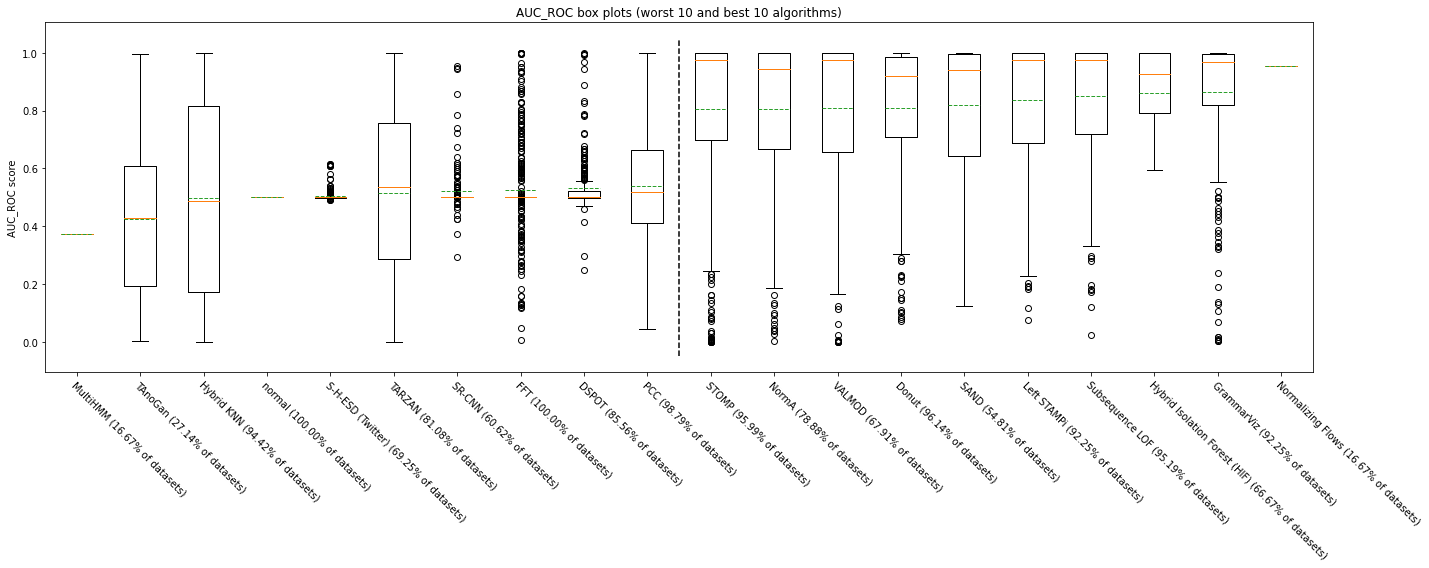

In [19]:
n_show = 20
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({dataset_count_lut[c]:6.2%} of datasets)"

plot_boxplot(df_asl, title="AUC_ROC box plots", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show, fliers=True)

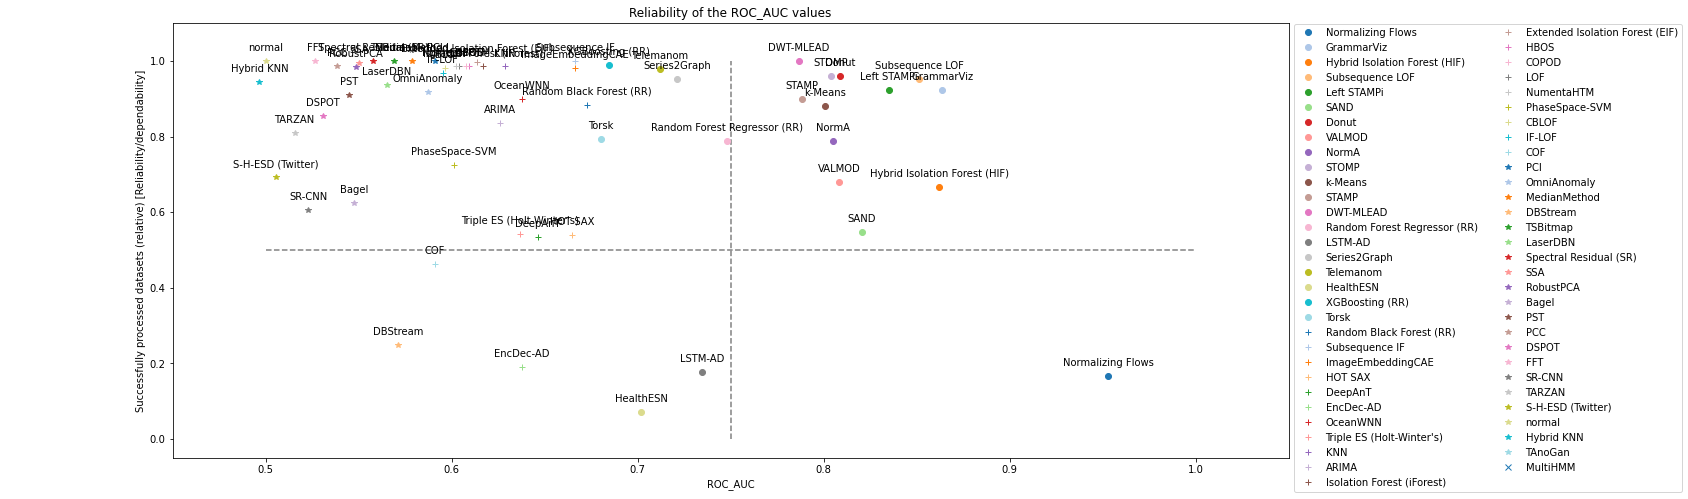

In [20]:
algo_auroc = df_overall_scores["mean"]
cycler = plt.cycler(marker=["o", "+", "*", "x", ".", "X"]) * plt.cycler(color=plt.get_cmap("tab20").colors)

fig = plt.figure()
ax = fig.gca()
ax.set_prop_cycle(cycler)
for c in df_overall_scores.index:
    x = algo_auroc[c]
    y = dataset_count_lut[c]
    ax.plot(x, y, label=c, linestyle="")
    ax.annotate(c, (x, y), textcoords="offset points", xytext=(0, 10), ha="center")

# add vline to separate bad and good algos
ax.vlines([0.75], 0, 1, colors="grey", linestyles="dashed")
ax.hlines([0.5], 0.5, 1, colors="grey", linestyles="dashed")
ax.set_xlabel("ROC_AUC")
ax.set_ylabel("Successfully processed datasets (relative) [Reliability/dependability]")
ax.set_title("Reliability of the ROC_AUC values")
ax.set_xlim(0.45, 1.05)
ax.set_ylim(-0.05, 1.1)
ax.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1.01))
fig.show()

#### Best algorithms (based on mean ROC_AUC)

In [21]:
df_overall_scores.head()

,min,mean,median,max
algorithm,,,,
Normalizing Flows,0.952979,0.952979,0.952979,0.952979
GrammarViz,0.002682,0.863841,0.967015,1.000000
Hybrid Isolation Forest (HIF),0.592981,0.862163,0.927876,0.999918
Subsequence LOF,0.025229,0.851512,0.974820,1.000000
Left STAMPi,0.074078,0.834977,0.974889,1.000000


#### Worst algorithms (based on mean ROC_AUC)

In [22]:
df_overall_scores.tail()

,min,mean,median,max
algorithm,,,,
S-H-ESD (Twitter),0.491007,0.505554,0.500000,0.615163
normal,0.500000,0.500000,0.500000,0.500000
Hybrid KNN,0.000004,0.496684,0.487976,1.000000
TAnoGan,0.001404,0.424400,0.429444,0.996066
MultiHMM,0.374354,0.374354,0.374354,0.374354


#### Scores of best algorithms

Please select a dataset (and algorithm if needed):

/tmp/ipykernel_5881/202798847.py:32: UserWarning: No ROC_AUC score found! Probably Hybrid Isolation Forest (HIF) was not executed on ('KDD-TSAD', '001_UCR_Anomaly_DISTORTED1sddb40').
  warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_id}.")
/tmp/ipykernel_5881/202798847.py:32: UserWarning: No ROC_AUC score found! Probably Normalizing Flows was not executed on ('KDD-TSAD', '001_UCR_Anomaly_DISTORTED1sddb40').
  warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_id}.")


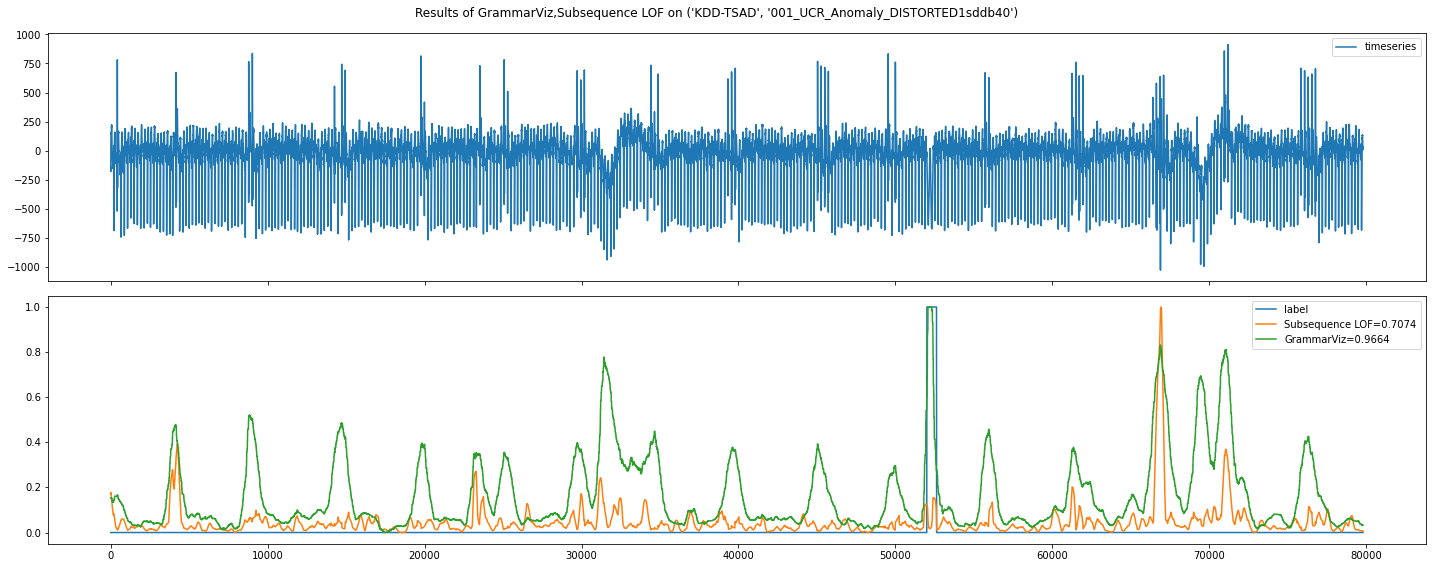

In [23]:
dataset_name = ("KDD-TSAD", "001_UCR_Anomaly_DISTORTED1sddb40")
algorithm_name = None
n_algos = 4

plot_scores(algorithm_name if algorithm_name else df_asl.columns[-n_algos:].to_list(), dataset_name)

### Runtime-weighted AUC_ROC scores

/tmp/ipykernel_5881/994922933.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


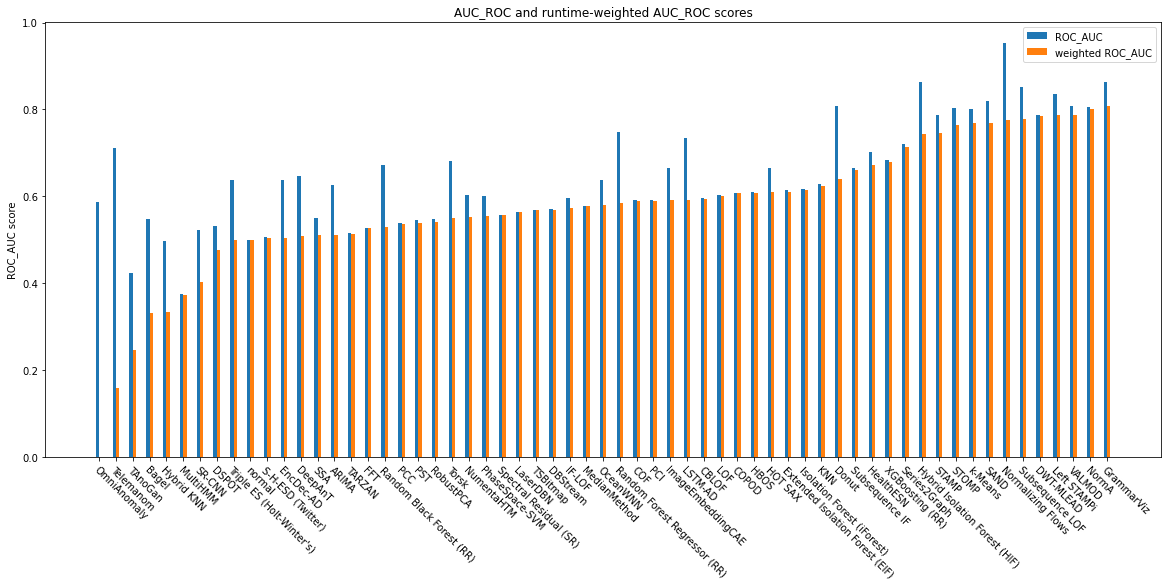

In [24]:
df_tmp = df.pivot_table(index="algorithm", values=["ROC_AUC", "overall_time"], aggfunc="mean")

from sklearn.preprocessing import MinMaxScaler
df_tmp["overall_time"] = 1 - MinMaxScaler(feature_range=(1e-6, 1)).fit_transform(df_tmp["overall_time"].values.reshape(-1, 1)).reshape(-1)
df_tmp = df_tmp.replace(0, np.nan)
df_tmp["weighted ROC_AUC"] = df_tmp["ROC_AUC"] * df_tmp["overall_time"]

df_tmp = df_tmp.sort_values(by="weighted ROC_AUC", ascending=True, na_position="first")
df_tmp.reset_index(drop=False, inplace=True)

if default_use_plotly:
    fig = px.bar(df_tmp, x="algorithm", y=["ROC_AUC", "weighted ROC_AUC"], hover_data=["overall_time"], barmode="group")
    py.iplot(fig)
else:
    fig = plt.figure()
    ax = fig.gca()
    ax.bar(df_tmp["algorithm"], df_tmp["ROC_AUC"], label="ROC_AUC", width=-0.2, align="edge")
    ax.bar(df_tmp["algorithm"], df_tmp["weighted ROC_AUC"], label="weighted ROC_AUC", width=0.2, align="edge")
    ax.set_ylabel("ROC_AUC score")
    ax.set_title(f"AUC_ROC and runtime-weighted AUC_ROC scores")
    ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
    ax.legend()
    fig.show()

### Comparison of errors and quality

### Algorithm runtime assessment

In [25]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_runtime = df.pivot_table(index="algorithm", values="overall_time", aggfunc=aggregations)
df_overall_runtime.columns = aggregations
df_overall_runtime = df_overall_runtime.sort_values(by=dominant_aggregation, ascending=True)


df_arl = df.pivot(index="algorithm", columns=["collection", "dataset"], values="overall_time")
df_arl = df_arl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_arl[dominant_aggregation] = df_arl.agg(dominant_aggregation, axis=1)
df_arl = df_arl.sort_values(by=dominant_aggregation, ascending=True)
df_arl = df_arl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_runtime.T)

/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


algorithm,normal,MedianMethod,MultiHMM,TSBitmap,FFT,Spectral Residual (SR),PCC,COPOD,PCI,DWT-MLEAD,HBOS,COF,LaserDBN,DBStream,TARZAN,Isolation Forest (iForest),Extended Isolation Forest (EIF),S-H-ESD (Twitter),NormA,CBLOF,LOF,KNN,XGBoosting (RR),Subsequence IF,Series2Graph,PST,RobustPCA,VALMOD,IF-LOF,k-Means,HealthESN,STOMP,STAMP,Left STAMPi,SAND,GrammarViz,SSA,PhaseSpace-SVM,HOT SAX,NumentaHTM,Subsequence LOF,OceanWNN,DSPOT,ImageEmbeddingCAE,Hybrid Isolation Forest (HIF),ARIMA,Normalizing Flows,Torsk,LSTM-AD,Donut,EncDec-AD,Random Black Forest (RR),DeepAnT,Triple ES (Holt-Winter's),Random Forest Regressor (RR),SR-CNN,Hybrid KNN,Bagel,TAnoGan,Telemanom,OmniAnomaly
min,0.000012,2.076952,0.000000,1.945044,2.681932,2.883614,0.000000,0.000000,3.875088,4.743346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.106269,3.894118,4.318261,5.008866,6.639056,7.537926,7.730976,8.846128,9.266961,9.294021,10.445739,11.635061,13.101390,16.190140,17.447915,24.478511,27.878309,30.990388,31.620133,32.456041,44.680391,46.231657,59.168977,60.211866,64.039530,74.100535,86.972576,162.207268,232.731489,261.068193,272.020779,321.588718,349.408276,369.089747,407.308982,423.624346,472.126888,493.745104,528.685526,551.304947,569.978696,599.120212,663.534409,742.384069,899.761808,1198.017598,1215.694674,1249.926010,1274.755561,1364.147161,1373.06813,1389.266114,1391.887546,1415.127649,1425.490321,1507.226475,2149.877942,2574.240027,2751.206956,5087.394450,6556.128354
median,0.000029,3.105221,0.000000,4.314352,4.037274,4.395650,7.146049,8.420726,6.045519,7.610091,10.059001,0.000000,12.322917,0.000000,13.717865,13.803896,11.073932,14.614584,6.954176,11.904787,7.544958,7.395956,32.450420,17.082791,24.888920,28.198014,19.596643,13.478435,11.640492,92.324329,0.000000,13.956870,21.258610,58.338694,44.149107,23.213278,33.852945,17.696841,40.196008,135.438887,19.352421,303.093625,152.677766,362.568806,452.662441,688.008846,0.000000,451.329749,0.000000,421.990548,0.00000,607.977246,615.816312,233.299160,612.847569,1077.806852,1403.992943,1712.865320,0.000000,6670.758383,7301.900660
max,43.745981,13.302432,25.909564,39.801842,216.158157,219.666790,18.268339,20.842885,132.264875,50.699514,18.913059,99.270062,38.175993,1660.356731,301.169038,174.393685,250.260997,492.669939,823.349294,901.509294,3713.797327,3605.892107,298.971387,700.461237,1448.327115,649.907190,1653.576679,2456.046883,6845.900580,3524.274057,6496.774690,6648.911228,6332.622833,5223.632345,5181.015772,6242.518002,7169.032209,6333.147421,7090.744080,7095.790262,7202.949723,5879.059969,6122.570307,8771.858068,2665.674981,6918.718124,7294.168046,7145.158498,9206.007954,10367.274630,9190.45852,7010.469121,7235.367741,7196.171065,6583.578540,6325.222928,8146.323903,14312.044568,13125.346192,10712.748909,8319.589563


/tmp/ipykernel_5881/2504827116.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


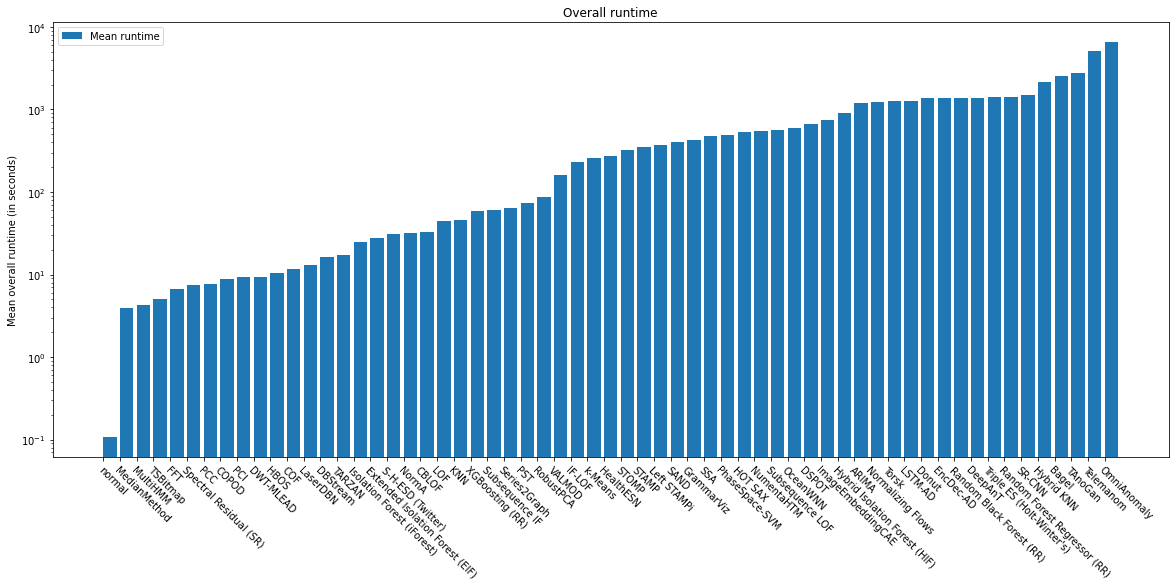

In [26]:
df_tmp = df_overall_runtime.reset_index()

fig = plt.figure()
ax = fig.gca()
ax.bar(df_tmp["algorithm"], df_tmp["mean"], label="Mean runtime", align="edge")
ax.set_ylabel("Mean overall runtime (in seconds)")
ax.set_title(f"Overall runtime")
ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
ax.set_yscale("log")
ax.legend()
fig.show()

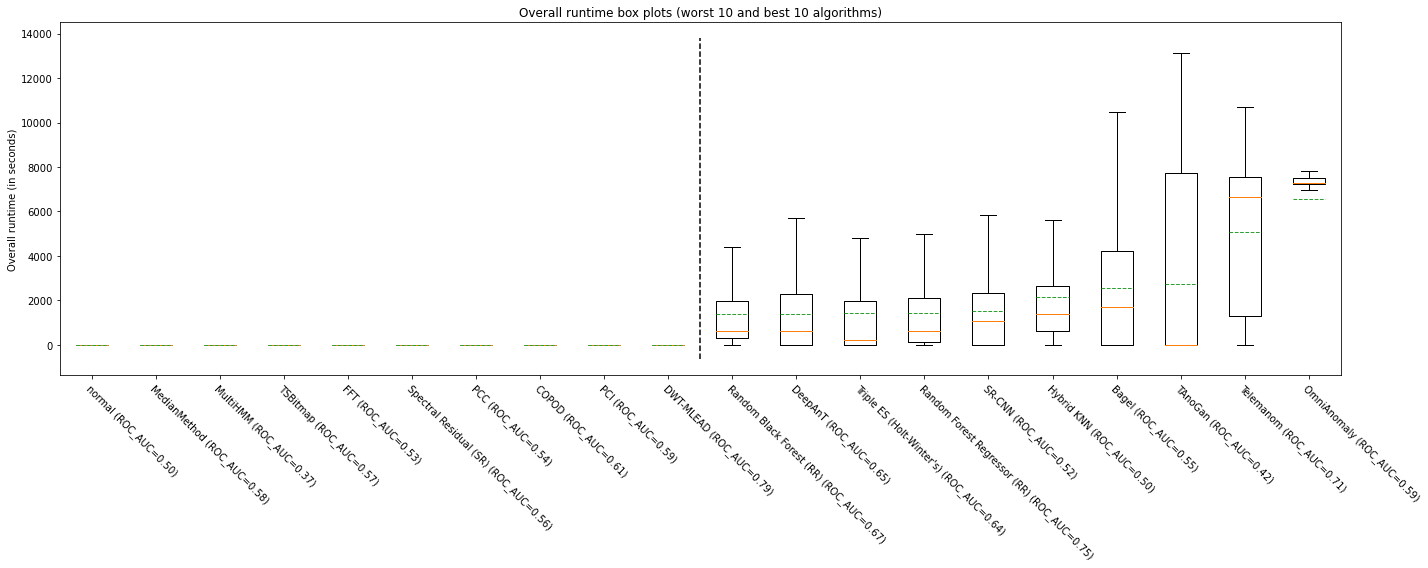

In [27]:
n_show = 20
fmt_label = lambda c: f"{c} (ROC_AUC={df_overall_scores.loc[c, 'mean']:.2f})"

plot_boxplot(df_arl, title="Overall runtime box plots", ax_label="Overall runtime (in seconds)", fmt_label=fmt_label, n_show=n_show)

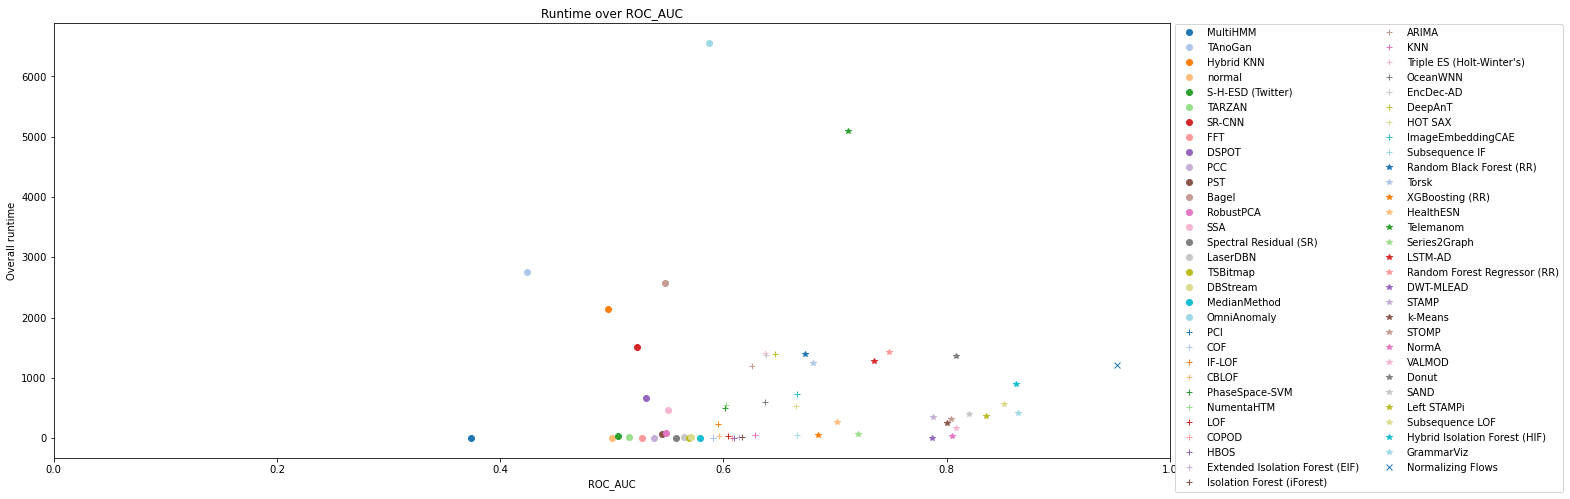

In [28]:
df_tmp = df.groupby(by="algorithm")[["ROC_AUC", "overall_time"]].mean().sort_values("ROC_AUC").T
cycler = plt.cycler(marker=["o", "+", "*", "x", ".", "X"]) * plt.cycler(color=plt.get_cmap("tab20").colors)

fig = plt.figure()
ax = fig.gca()
ax.set_prop_cycle(cycler)
for c in df_tmp:
    x = df_tmp.loc["ROC_AUC", c]
    y = df_tmp.loc["overall_time", c]
    ax.plot(x, y, label=c, linestyle="")
    #ax.annotate(c, (x, y), textcoords="offset points", xytext=(0, 10), ha="center")
ax.set_ylabel("Overall runtime")
ax.set_xlabel("ROC_AUC")
ax.set_title("Runtime over ROC_AUC")
#ax.set_yscale("log")
ax.set_xlim(0, 1)
ax.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1.01))
fig.show()

## Multivariate analysis

In this analysis, we only consider multivariate algorithms and datasets.

In [29]:
df_multi = df[(df["algo_input_dimensionality"] == "MULTIVARIATE") & (df["dataset_input_dimensionality"] == "MULTIVARIATE")]
text = "Multivariate algorithms:\n"
for algo in sorted(df_multi["algorithm"].unique()):
    text += f"- {algo}\n"
display(Markdown(text))

Multivariate algorithms:
- CBLOF
- COF
- COPOD
- DBStream
- DeepAnT
- EncDec-AD
- Extended Isolation Forest (EIF)
- HBOS
- HealthESN
- Hybrid Isolation Forest (HIF)
- Hybrid KNN
- IF-LOF
- Isolation Forest (iForest)
- KNN
- LOF
- LSTM-AD
- LaserDBN
- MultiHMM
- Normalizing Flows
- OmniAnomaly
- PCC
- Random Black Forest (RR)
- RobustPCA
- TAnoGan
- Telemanom
- Torsk
- k-Means
- normal


### Quality overview

In [30]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_multi_overall_scores = df_multi.pivot_table(index="algorithm", values="ROC_AUC", aggfunc=aggregations)
df_multi_overall_scores.columns = aggregations
df_multi_overall_scores = df_multi_overall_scores.sort_values(by=dominant_aggregation, ascending=False)


df_multi_asl = df_multi.pivot(index="algorithm", columns=["collection", "dataset"], values="ROC_AUC")
df_multi_asl = df_multi_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_multi_asl[dominant_aggregation] = df_multi_asl.agg(dominant_aggregation, axis=1)
df_multi_asl = df_multi_asl.sort_values(by=dominant_aggregation, ascending=True)
df_multi_asl = df_multi_asl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_multi_overall_scores.T)

/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


algorithm,Hybrid Isolation Forest (HIF),Telemanom,k-Means,OmniAnomaly,Isolation Forest (iForest),COPOD,PCC,COF,CBLOF,HBOS,Extended Isolation Forest (EIF),RobustPCA,KNN,LOF,Torsk,IF-LOF,DBStream,Hybrid KNN,normal,TAnoGan,DeepAnT
min,0.999030,0.656560,0.407587,0.543379,0.438376,0.442014,0.421197,0.588605,0.379944,0.435518,0.344886,0.365208,0.005516,0.378237,0.375232,0.362802,0.000864,0.5,0.5,0.092897,0.024786
mean,0.999474,0.897634,0.809606,0.804522,0.714884,0.696525,0.693290,0.679332,0.674722,0.669793,0.669206,0.659259,0.587278,0.578392,0.566071,0.560238,0.503143,0.5,0.5,0.092897,0.024786
median,0.999474,0.967127,0.877089,0.859777,0.670781,0.650894,0.668005,0.610866,0.657864,0.616960,0.647653,0.716067,0.613603,0.557743,0.600586,0.543392,0.507718,0.5,0.5,0.092897,0.024786
max,0.999918,0.999450,1.000000,0.972710,0.999481,0.999483,0.997525,0.838523,0.987729,0.988636,0.953938,0.939711,0.997124,0.996454,0.799697,0.996444,0.638923,0.5,0.5,0.092897,0.024786


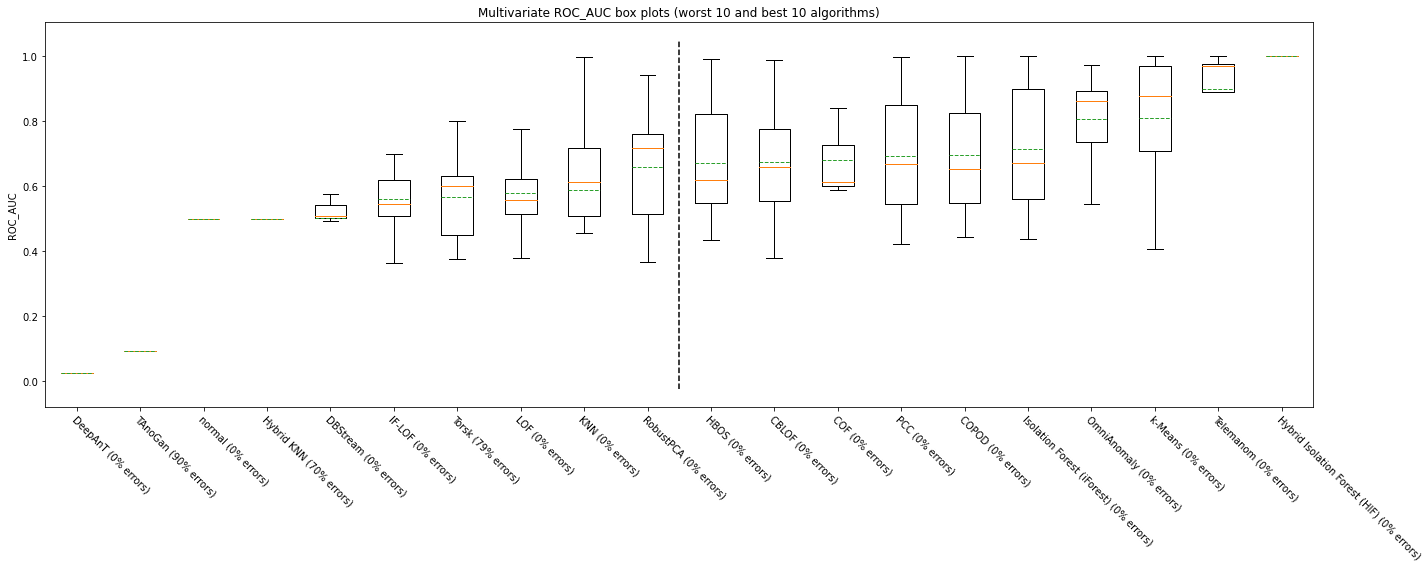

In [31]:
n_show = len(df_multi_asl.columns)
n_show = n_show // 2

df_multi_error_counts = df_multi.pivot_table(index="algorithm", columns="status", values="repetition", aggfunc="count")
df_multi_error_counts["ALL"] = df_multi_error_counts.sum(axis=1)
df_multi_error_counts["ERROR"] = (df_multi_error_counts["Status.ERROR"] + df_multi_error_counts["Status.TIMEOUT"])
df_multi_error_counts = df_multi_error_counts.fillna(value=0).astype(np.int64).sort_values("Status.ERROR", ascending=False)
fmt_label = lambda c: f"{c} ({df_multi_error_counts.loc[c, 'ERROR']/df_multi_error_counts.loc[c, 'ALL']:.0%} errors)"

plot_boxplot(df_multi_asl, title="Multivariate ROC_AUC box plots", ax_label="ROC_AUC", fmt_label=fmt_label)

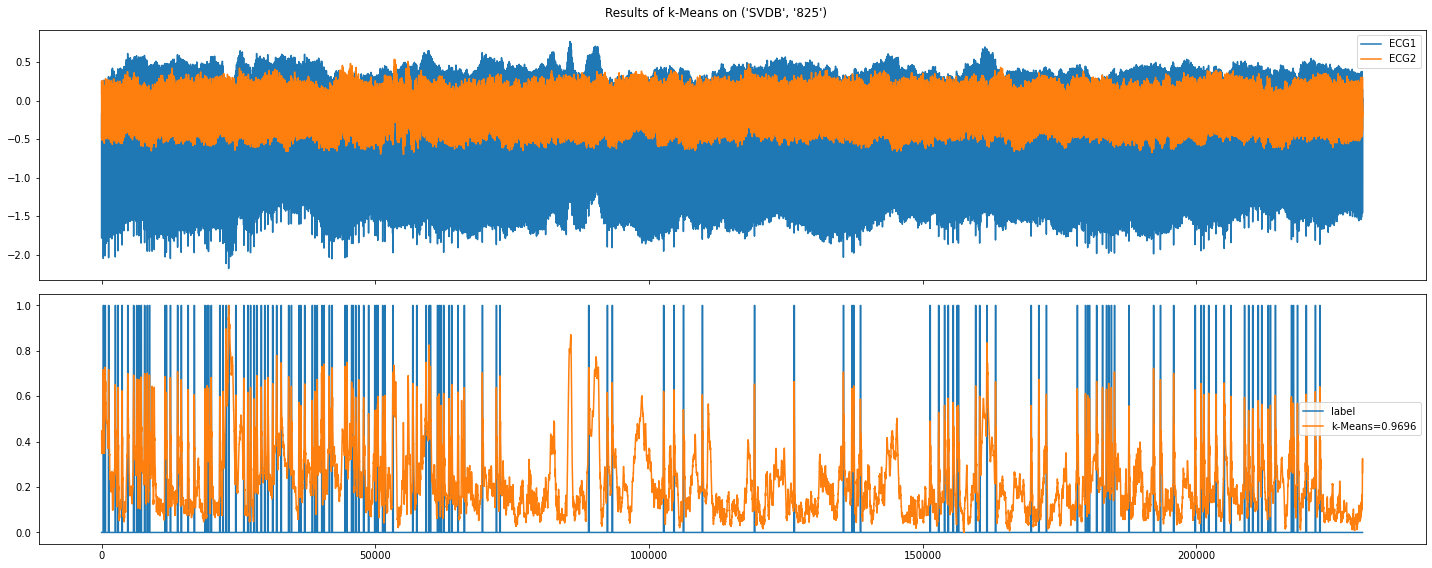

In [32]:
plot_scores("k-Means", ("SVDB", "825")) # ("KDD-TSAD", "001_UCR_Anomaly_DISTORTED1sddb40"))

In [33]:
dmgr.get_detailed_metadata(("SVDB", "825")).contamination

0.06357638888888889

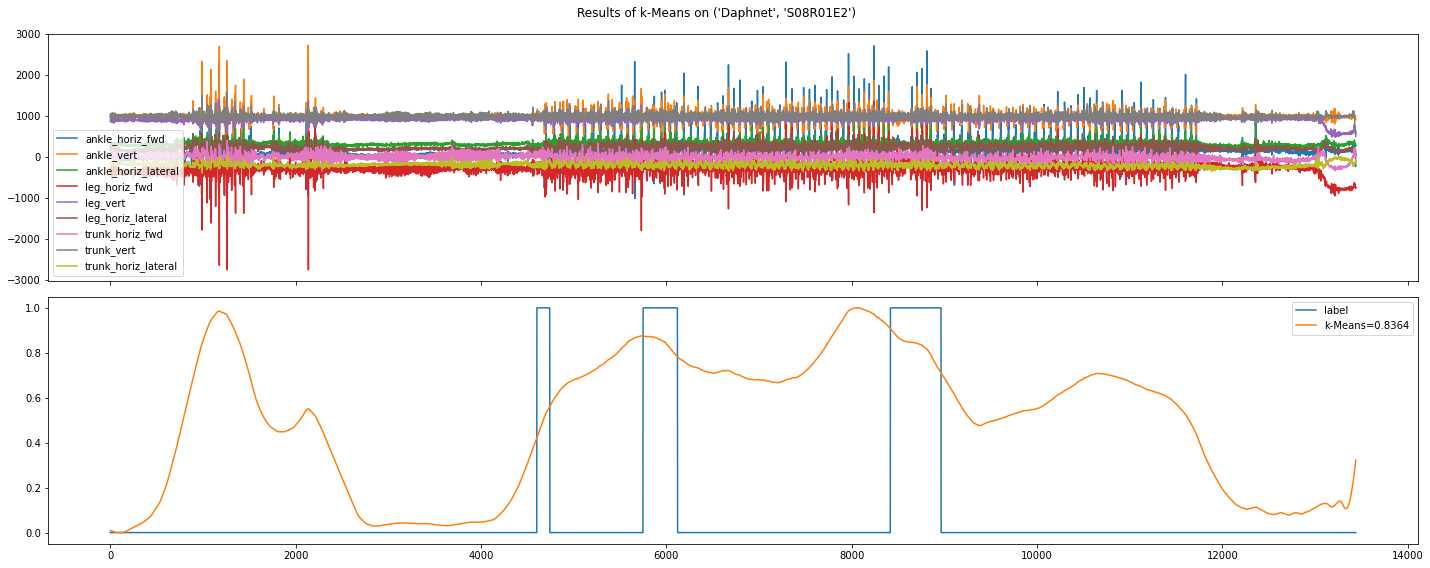

In [34]:
plot_scores("k-Means", ("Daphnet", "S08R01E2"))

In [35]:
df[(df["collection"] == "Daphnet") & (df["algorithm"] == "k-Means")]

,algorithm,collection,dataset,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,train_main_time,execute_preprocess_time,...,error_message,repetition,hyper_params,hyper_params_id,ROC_AUC,PR_AUC,AVERAGE_PRECISION,overall_time,RANGE_PR_AUC,error_category
8171,k-Means,Daphnet,S08R01E2,UNSUPERVISED,MULTIVARIATE,UNSUPERVISED,MULTIVARIATE,NaN,NaN,NaN,...,NaN,1,"{""anomaly_window_size"": 547, ""n_clusters"": 50,...",cfa90897b46b014c796de1ba98df27f8,0.836391,0.222672,0.222895,1585.299012,NaN,- OK -
8172,k-Means,Daphnet,S02R02E0,UNSUPERVISED,MULTIVARIATE,UNSUPERVISED,MULTIVARIATE,NaN,NaN,NaN,...,DockerAlgorithmFailedError('Please consider lo...,1,"{""anomaly_window_size"": 1178, ""n_clusters"": 50...",cfa90897b46b014c796de1ba98df27f8,NaN,NaN,NaN,0.000000,NaN,- OOM -
8173,k-Means,Daphnet,S01R01E1,UNSUPERVISED,MULTIVARIATE,UNSUPERVISED,MULTIVARIATE,NaN,NaN,NaN,...,DockerAlgorithmFailedError('Please consider lo...,1,"{""anomaly_window_size"": 973, ""n_clusters"": 50,...",cfa90897b46b014c796de1ba98df27f8,NaN,NaN,NaN,0.000000,NaN,- OOM -
8174,k-Means,Daphnet,S09R01E1,UNSUPERVISED,MULTIVARIATE,UNSUPERVISED,MULTIVARIATE,NaN,NaN,NaN,...,NaN,1,"{""anomaly_window_size"": 1430, ""n_clusters"": 50...",cfa90897b46b014c796de1ba98df27f8,0.567861,0.451483,0.451594,2888.878367,NaN,- OK -


## Detailed analysis of certain algorithm or dataset aspects

### Best algorithm of algorithm family

#### Method family `baseline`

,,ROC_AUC,overall_time
algo_training_type,algorithm,,
UNSUPERVISED,normal,0.50,0.11


/tmp/ipykernel_5881/202798847.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


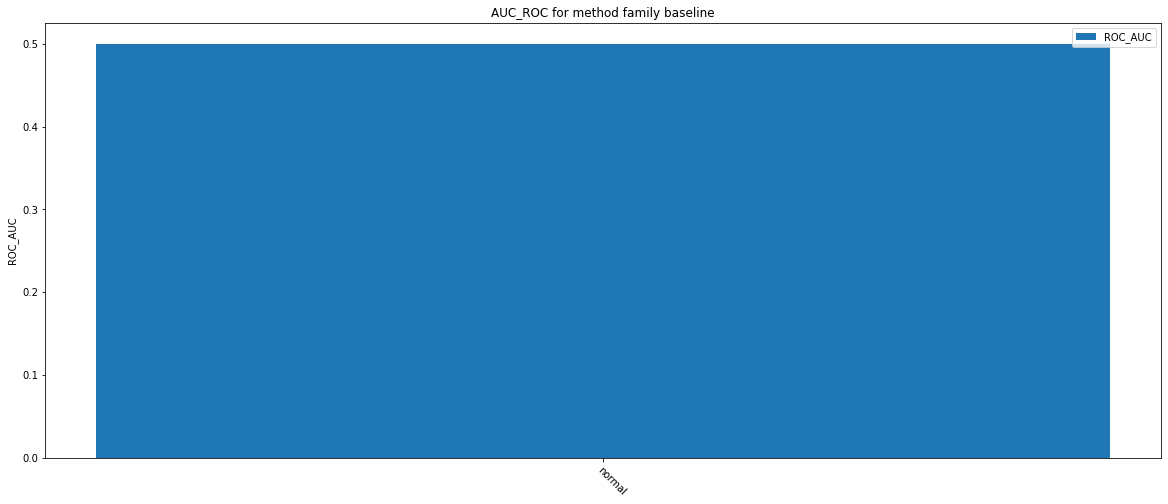

#### Method family `compression`

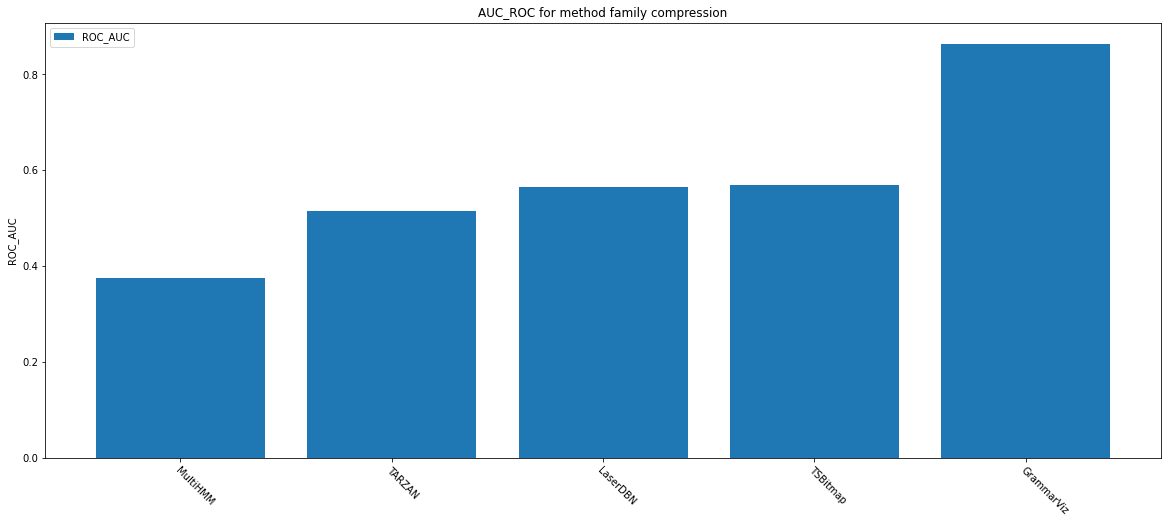

#### Method family `distance`

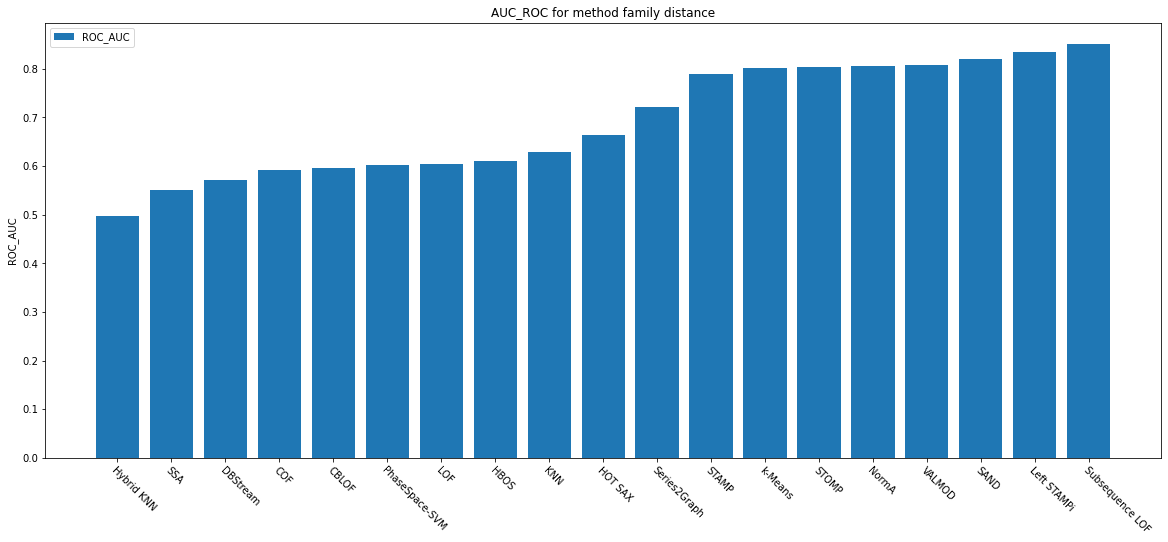

#### Method family `distribution`

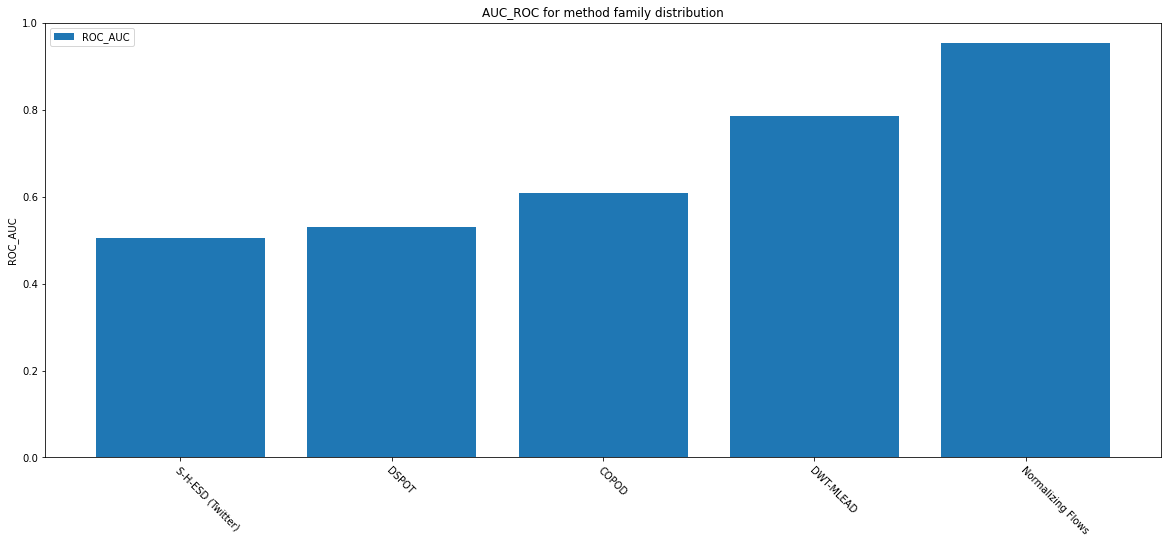

#### Method family `forecasting`

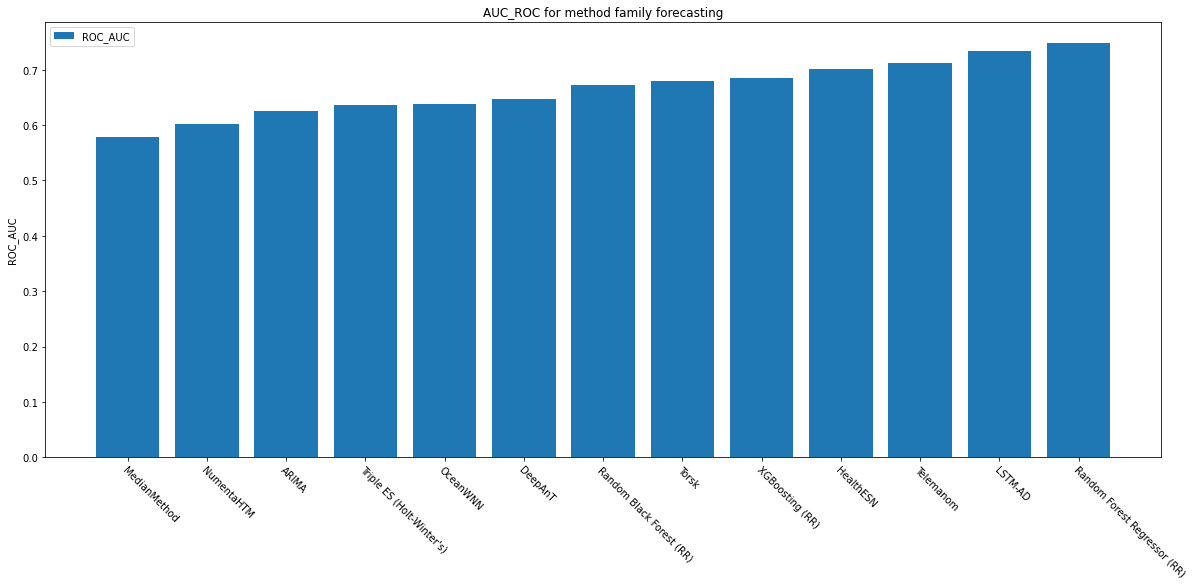

#### Method family `reconstruction`

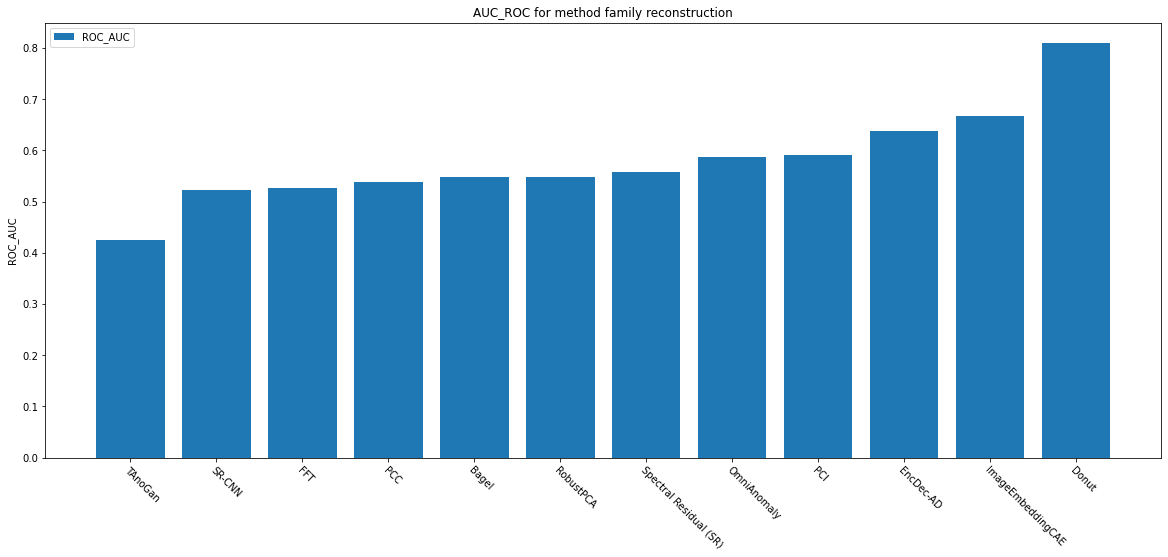

#### Method family `trees`

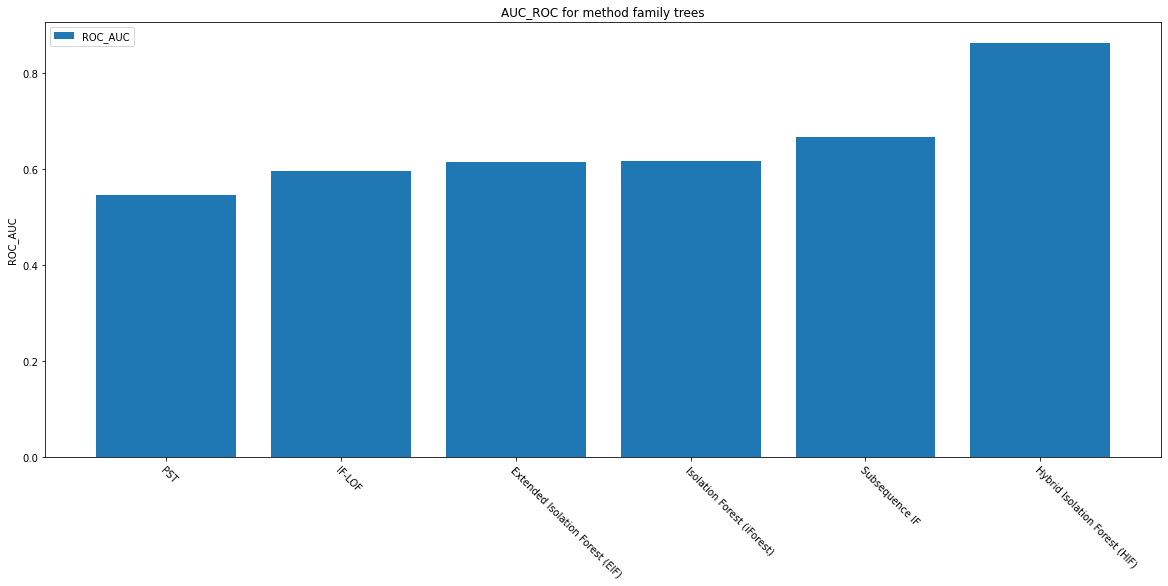

In [36]:
algo_metadata = [
  {"name": "AD-LTI", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "ARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Autoencoder (AE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Bagel", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "CBLOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COPOD", "research_area": "Ourlier Detection", "method_family": "distribution"},
  {"name": "DenoisingAutoEncoder (DAE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DBStream", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "DeepAnT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "DeepNAP", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Donut", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DSPOT", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "DWT-MLEAD", "research_area": "Signal Analysis", "method_family": "distribution"},
  {"name": "Extended Isolation Forest (EIF)", "research_area": "Classic Machine Learning", "method_family": "trees"},
  {"name": "EncDec-AD", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Ensemble GI", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "FFT", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "Random Forest Regressor (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "XGBoosting (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "GrammarViz", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "HBOS", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "HealthESN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Hybrid Isolation Forest (HIF)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "HOT SAX", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Hybrid KNN", "research_area": "Deep Learning", "method_family": "distance"},
  {"name": "IF-LOF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Isolation Forest (iForest)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "ImageEmbeddingCAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "k-Means", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "KNN", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "LaserDBN", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "Left STAMPi", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "LSTM-AD", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "LSTM-VAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MedianMethod", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "MSCRED", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MTAD-GAT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "MultiHMM", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "NormA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Normalizing Flows", "research_area": "Deep Learning", "method_family": "distribution"},
  {"name": "NoveltySVR", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "NumentaHTM", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OceanWNN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OmniAnomaly", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "PCC", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "PCI", "research_area": "Statistics (Regression & Forecasting)", "method_family": "reconstruction"},
  {"name": "PhaseSpace-SVM", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "PST", "research_area": "Data Mining", "method_family": "trees"},
  {"name": "Random Black Forest (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "RobustPCA", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "S-H-ESD (Twitter)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "SAND", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "SARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Series2Graph", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Spectral Residual (SR)", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "SR-CNN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "SSA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STAMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STOMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Subsequence Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "Subsequence IF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Subsequence LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "TAnoGAN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "TARZAN", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Telemanom", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Torsk", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Triple ES (Holt-Winter's)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "TSBitmap", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "VALMOD", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "normal", "research_area": "None", "method_family": "baseline"},
  {"name": "Random", "research_area": "None", "method_family": "baseline"},
  {"name": "increasing", "research_area": "None", "method_family": "baseline"},
]

algo_meta_lut = {}
for obj in algo_metadata:
    algo_meta_lut[obj["name"]] = obj
# fix some typos:
algo_meta_lut["TAnoGan"] = algo_meta_lut["TAnoGAN"]
algo_meta_lut["random"] = algo_meta_lut["Random"]

df["algo_family"] = df["algorithm"].apply(lambda algo: algo_meta_lut[algo]["method_family"])
df["algo_area"] = df["algorithm"].apply(lambda algo: algo_meta_lut[algo]["research_area"])

index_columns = ["algo_family", "algo_training_type", "algorithm"]
df_algo_families = df.groupby(by=index_columns)[["ROC_AUC", "overall_time"]].mean()

df_algo_families = df_algo_families.fillna(value=0)
df_algo_families = df_algo_families.reset_index().sort_values(by=["algo_training_type", "ROC_AUC"], ascending=False).set_index(index_columns)

families = np.unique(df_algo_families.index.get_level_values(0))
for family in families:
    display(Markdown(f"#### Method family `{family}`"))
    if default_use_plotly:
        py.iplot(ff.create_table(df_algo_families.loc[family], index=True))
    else:
        display(df_algo_families.loc[family].style.format("{:.2f}", na_rep=""))
    df_plot = df_algo_families.loc[family].reset_index()
    df_plot = df_plot.drop(columns=["algo_training_type", "overall_time"])
    df_plot = df_plot.sort_values(by="ROC_AUC", na_position="first")
    display(plot_algorithm_bars(df_plot, y_name="ROC_AUC", title=f"AUC_ROC for method family {family}"))
None

### Easy or hard datasets per algorithm family

## Dataset assessment

- quality overview
- runtime overview
- datasets, for which the most algorithms fail
- datasets, for which good algorithms fail

### Dataset error analysis

#### Dataset error overview

In [37]:
# Overview about datasets
index_columns = ["dataset_training_type", "dataset_input_dimensionality", "collection", "dataset"]
df_dataset_error_counts = df.pivot_table(index=index_columns, columns=["status"], values="repetition", aggfunc="count")
df_dataset_error_counts = df_dataset_error_counts.fillna(value=0).astype(np.int64)
df_dataset_error_counts = df_dataset_error_counts.reset_index().sort_values(by=["dataset_input_dimensionality", "Status.ERROR"], ascending=False).set_index(index_columns)
df_dataset_error_counts["ALL"] = df_dataset_error_counts["Status.ERROR"] + df_dataset_error_counts["Status.OK"] + df_dataset_error_counts["Status.TIMEOUT"]

for tpe in ["SEMI_SUPERVISED", "SUPERVISED", "UNSUPERVISED"]:
    if tpe in df_dataset_error_counts.index:
        print(tpe)
        if default_use_plotly:
            py.iplot(ff.create_table(df_dataset_error_counts.loc[tpe], index=True))
        else:
            display(df_dataset_error_counts.loc[tpe])

SEMI_SUPERVISED


status                                                                         Status.ERROR  \
dataset_input_dimensionality collection dataset                                               
UNIVARIATE                   KDD-TSAD   108_UCR_Anomaly_NOISEresperation2                16   
                                        187_UCR_Anomaly_resperation2                     16   
                                        241_UCR_Anomaly_taichidbS0715Master              14   
                                        079_UCR_Anomaly_DISTORTEDresperation2            13   
                                        184_UCR_Anomaly_resperation10                    11   
...                                                                                     ...   
MULTIVARIATE                 SMD        machine-1-1                                       8   
                             Exathlon   4_1_100000_61-29                                  7   
                             SMD        machine-2-4                                       7   
                                        machine-3-1                                       7   
                                        machine-3-3                                       7   

status                                                                         Status.OK  \
dataset_input_dimensionality collection dataset                                            
UNIVARIATE                   KDD-TSAD   108_UCR_Anomaly_NOISEresperation2             31   
                                        187_UCR_Anomaly_resperation2                  33   
                                        241_UCR_Anomaly_taichidbS0715Master           30   
                                        079_UCR_Anomaly_DISTORTEDresperation2         34   
                                        184_UCR_Anomaly_resperation10                 34   
...                                                                                  ...   
MULTIVARIATE                 SMD        machine-1-1                                   12   
                             Exathlon   4_1_100000_61-29                              13   
                             SMD        machine-2-4                                   14   
                                        machine-3-1                                   13   
                                        machine-3-3                                   13   

status                                                                         Status.TIMEOUT  \
dataset_input_dimensionality collection dataset                                                 
UNIVARIATE                   KDD-TSAD   108_UCR_Anomaly_NOISEresperation2                  11   
                                        187_UCR_Anomaly_resperation2                        9   
                                        241_UCR_Anomaly_taichidbS0715Master                14   
                                        079_UCR_Anomaly_DISTORTEDresperation2              11   
                                        184_UCR_Anomaly_resperation10                      13   
...                                                                                       ...   
MULTIVARIATE                 SMD        machine-1-1                                         5   
                             Exathlon   4_1_100000_61-29                                    5   
                             SMD        machine-2-4                                         4   
                                        machine-3-1                                         5   
                                        machine-3-3                                         5   

status                                                                         ALL  
dataset_input_dimensionality collection dataset                                     
UNIVARIATE                   KDD-TSAD   108_UCR_Anomaly_NOISEresperation2       58  
                                        187_UCR_An

SUPERVISED


status                                                                        Status.ERROR  \
dataset_input_dimensionality collection dataset                                              
UNIVARIATE                   IOPS       adb2fde9-8589-3f5b-a410-5fe14386c7af             6   
                                        ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa             6   
                                        301c70d8-1630-35ac-8f96-bc1b6f4359ea             3   
                                        c02607e8-7399-3dde-9d28-8a8da5e5d251             2   
MULTIVARIATE                 Exathlon   5_1_100000_63-64                                 3   
                                        5_1_100000_64-63                                 3   

status                                                                        Status.OK  \
dataset_input_dimensionality collection dataset                                           
UNIVARIATE                   IOPS       adb2fde9-8589-3f5b-a410-5fe14386c7af         27   
                                        ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa         30   
                                        301c70d8-1630-35ac-8f96-bc1b6f4359ea         38   
                                        c02607e8-7399-3dde-9d28-8a8da5e5d251         39   
MULTIVARIATE                 Exathlon   5_1_100000_63-64                             13   
                                        5_1_100000_64-63                             12   

status                                                                        Status.TIMEOUT  \
dataset_input_dimensionality collection dataset                                                
UNIVARIATE                   IOPS       adb2fde9-8589-3f5b-a410-5fe14386c7af               9   
                                        ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa               6   
                                        301c70d8-1630-35ac-8f96-bc1b6f4359ea               1   
                                        c02607e8-7399-3dde-9d28-8a8da5e5d251               1   
MULTIVARIATE                 Exathlon   5_1_100000_63-64                                   1   
                                        5_1_100000_64-63                                   2   

status                                                                        ALL  
dataset_input_dimensionality collection dataset                                    
UNIVARIATE                   IOPS       adb2fde9-8589-3f5b-a410-5fe14386c7af   42  
                                        ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa   42  
                                        301c70d8-1630-35ac-8f96-bc1b6f4359ea   42  
                                        c02607e8-7399-3dde-9d28-8a8da5e5d251   42  
MULTIVARIATE                 Exathlon   5_1_100000_63-64                       17  
                                        5_1_100000_64-63                       17

UNSUPERVISED


status                                                                 Status.ERROR  \
dataset_input_dimensionality collection dataset                                       
UNIVARIATE                   NAB        art_flatline                             14   
                                        art_daily_no_noise                        9   
                                        art_daily_perfect_square_wave             9   
                             Dodgers    101-freeway-traffic                       8   
                             NAB        art_daily_small_noise                     7   
...                                                                             ...   
MULTIVARIATE                 SVDB       825                                       1   
                                        888                                       1   
                             CalIt2     CalIt2-traffic                            0   
                             Daphnet    S08R01E2                                  0   
                                        S09R01E1                                  0   

status                                                                 Status.OK  \
dataset_input_dimensionality collection dataset                                    
UNIVARIATE                   NAB        art_flatline                          25   
                                        art_daily_no_noise                    30   
                                        art_daily_perfect_square_wave         30   
                             Dodgers    101-freeway-traffic                   29   
                             NAB        art_daily_small_noise                 32   
...                                                                          ...   
MULTIVARIATE                 SVDB       825                                   12   
                                        888                                   13   
                             CalIt2     CalIt2-traffic                        14   
                             Daphnet    S08R01E2                              14   
                                        S09R01E1                              14   

status                                                                 Status.TIMEOUT  \
dataset_input_dimensionality collection dataset                                         
UNIVARIATE                   NAB        art_flatline                                0   
                                        art_daily_no_noise                          0   
                                        art_daily_perfect_square_wave               0   
                             Dodgers    101-freeway-traffic                         2   
                             NAB        art_daily_small_noise                       0   
...                                                                               ...   
MULTIVARIATE                 SVDB       825                                         1   
                                        888                                         0   
                             CalIt2     CalIt2-traffic                              0   
                             Daphnet    S08R01E2                                    0   
                                        S09R01E1                                    0   

status                                                                 ALL  
dataset_input_dimensionality collection dataset                             
UNIVARIATE                   NAB        art_flatline                    39  
                                        art_daily_no_noise              39  
                                        art_daily_perfect_square_wave   39  
                             Dodgers    101-freeway-traffic             39  
                             NAB        art_daily_small_noise           39  
...                                                                    ...  
M

In [38]:
index_columns = ["collection"]
df_tmp = df.pivot_table(index=index_columns, columns="error_category", values="repetition", aggfunc="count").fillna(0).astype(np.int_)
s_sum = df_tmp.sum(axis=1)
for c in df_tmp:
    df_tmp[c] = df_tmp[c] / s_sum
df_tmp

error_category,- OK -,- OOM -,- TIMEOUT -,Bug,Incompatible parameters,Invariance/assumption not met,LinAlgError,Max recursion depth exceeded,Model loading error,Not converged,TimeEval:IndexError,Wrong shape error,other,unexpected Inf or NaN
collection,,,,,,,,,,,,,,
CalIt2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Daphnet,0.892857,0.071429,0.035714,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Dodgers,0.743590,0.076923,0.051282,0.025641,0.025641,0.051282,0.000000,0.000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000
Exathlon,0.583333,0.154762,0.119048,0.023810,0.000000,0.095238,0.000000,0.000,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000
GHL,0.440000,0.350000,0.210000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Genesis,0.785714,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IOPS,0.797619,0.017857,0.101190,0.041667,0.023810,0.000000,0.000000,0.000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000
KDD-TSAD,0.815586,0.045793,0.107793,0.016483,0.007862,0.003724,0.000276,0.002,0.000138,0.000000,0.000000,0.000207,0.000138,0.000000
Keogh,0.919540,0.040230,0.011494,0.011494,0.017241,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/tmp/ipykernel_5881/167311759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(index, rotation=-45, ha="left", rotation_mode="anchor")


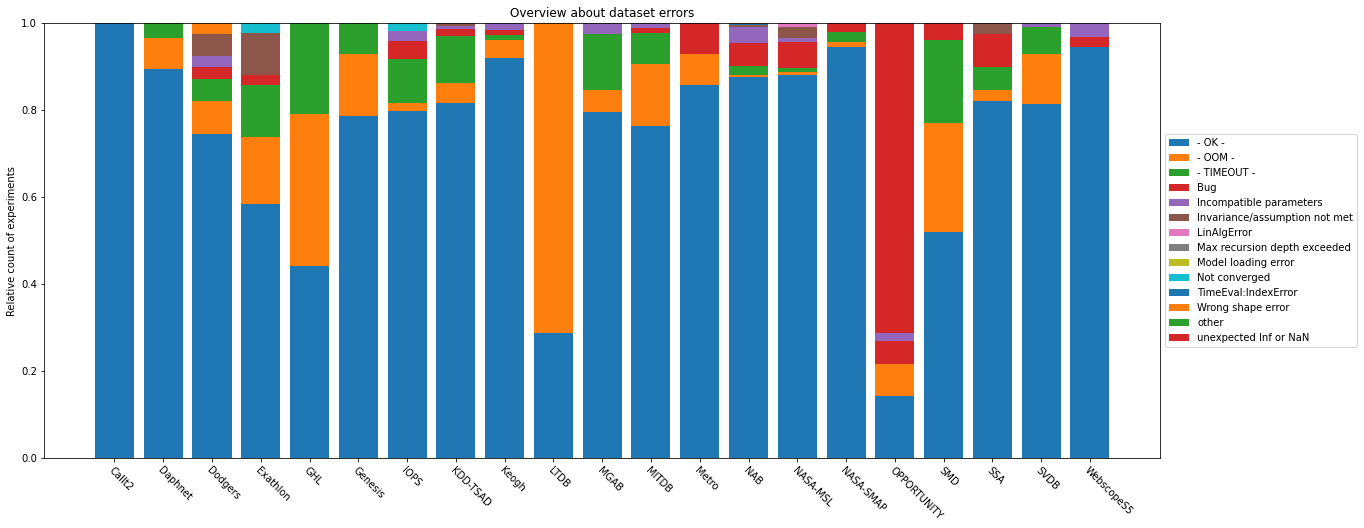

In [39]:
index = df_tmp.index
fig = plt.figure()
ax = fig.gca()
columns = sorted(df_tmp.columns)
ax.bar(index, df_tmp[columns[0]], label=columns[0])
for i in range(1, len(columns)):
    ax.bar(index, df_tmp[columns[i]], label=columns[i], bottom=df_tmp[columns[:i]].sum(axis=1))
ax.set_ylabel("Relative count of experiments")
ax.set_title("Overview about dataset errors")
ax.set_xticklabels(index, rotation=-45, ha="left", rotation_mode="anchor")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.set_cmap(plt.get_cmap("tab20"))
fig.show()

In [40]:
df_dataset_error_counts.reset_index()
col = "KDD-TSAD"
name = "108_UCR_Anomaly_NOISEresperation2"
df.loc[(df["collection"] == col) & (df["dataset"] == name), "error_category"]
index_columns = ["collection", "dataset"]
df_tmp = df.pivot_table(index=index_columns, columns="error_category", values="repetition", aggfunc="count").fillna(0).astype(np.int_)
s_sum = df_tmp.sum(axis=1)
for c in df_tmp:
    df_tmp[c] = df_tmp[c] / s_sum
df_tmp = df_tmp[df_tmp["- OK -"] < 0.85]

/tmp/ipykernel_5881/1735472469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(index, rotation=-45, ha="left", rotation_mode="anchor")


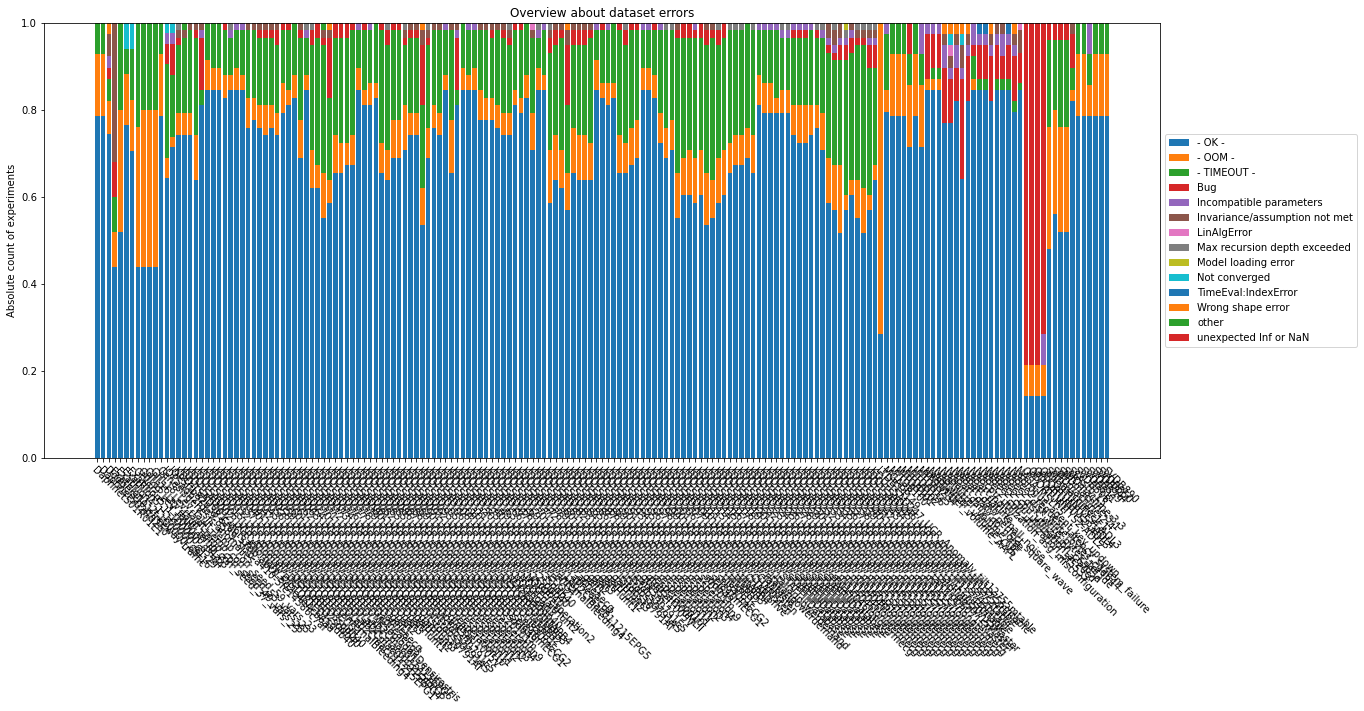

In [41]:
index = df_tmp.index.get_level_values(0).str.cat(df_tmp.index.get_level_values(1))
fig = plt.figure()
ax = fig.gca()
columns = sorted(df_tmp.columns)
ax.bar(index, df_tmp[columns[0]], label=columns[0])
for i in range(1, len(columns)):
    ax.bar(index, df_tmp[columns[i]], label=columns[i], bottom=df_tmp[columns[:i]].sum(axis=1))
ax.set_ylabel("Absolute count of experiments")
ax.set_title("Overview about dataset errors")
ax.set_xticklabels(index, rotation=-45, ha="left", rotation_mode="anchor")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.show()

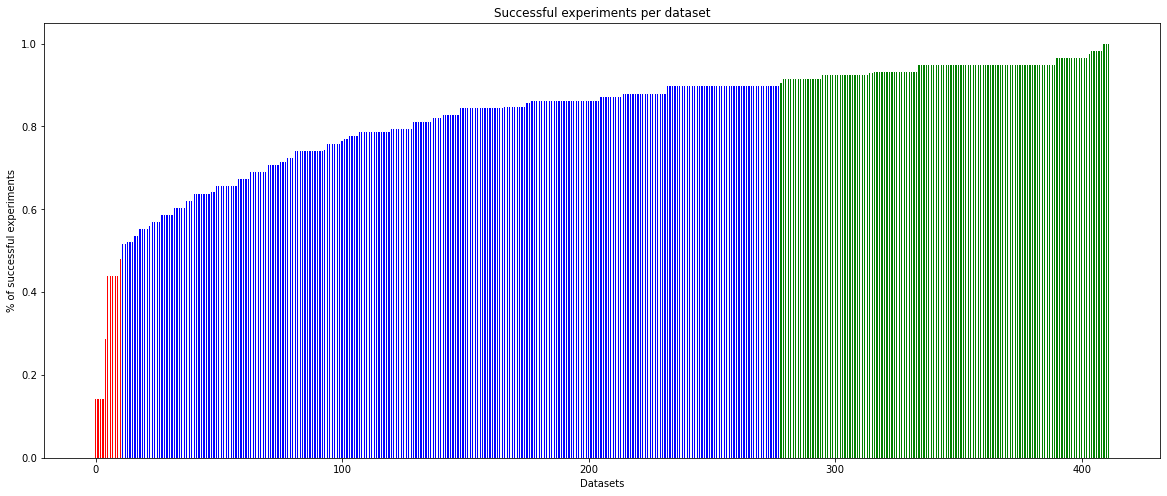

In [42]:
s = df_dataset_error_counts["Status.OK"] / df_dataset_error_counts["ALL"]
s = s.sort_values().reset_index(drop=True)

lower_threshold = 0.5
higher_threshold = 0.9

fig = plt.figure()
ax = fig.gca()
values = s[s < lower_threshold]
ax.bar(values.index, values.values, width=0.5, color="red")
values = s[~(s >= higher_threshold) & ~(s < lower_threshold)]
ax.bar(values.index, values.values, width=0.5, color="blue")
values = s[s >= higher_threshold]
ax.bar(values.index, values.values, width=0.5, color="green")
ax.set_xlabel("Datasets")
ax.set_ylabel("% of successful experiments")
ax.set_title("Successful experiments per dataset")
fig.show()

#### Datasets which all algorithms could process

In [43]:
df_dataset_error_counts[df_dataset_error_counts["ALL"] - df_dataset_error_counts["Status.OK"] == 0]

status                                                                        Status.ERROR  \
dataset_training_type dataset_input_dimensionality collection dataset                        
UNSUPERVISED          MULTIVARIATE                 CalIt2     CalIt2-traffic             0   
                                                   Daphnet    S08R01E2                   0   
                                                              S09R01E1                   0   

status                                                                        Status.OK  \
dataset_training_type dataset_input_dimensionality collection dataset                     
UNSUPERVISED          MULTIVARIATE                 CalIt2     CalIt2-traffic         14   
                                                   Daphnet    S08R01E2               14   
                                                              S09R01E1               14   

status                                                                        Status.TIMEOUT  \
dataset_training_type dataset_input_dimensionality collection dataset                          
UNSUPERVISED          MULTIVARIATE                 CalIt2     CalIt2-traffic               0   
                                                   Daphnet    S08R01E2                     0   
                                                              S09R01E1                     0   

status                                                                        ALL  
dataset_training_type dataset_input_dimensionality collection dataset              
UNSUPERVISED          MULTIVARIATE                 CalIt2     CalIt2-traffic   14  
                                                   Daphnet    S08R01E2         14  
                                                              S09R01E1         14

#### Datasets useful for statistical analysis

Datasets, for which at least 90% of algorithms were successful:

In [44]:
df_dataset_error_counts[df_dataset_error_counts["Status.OK"] >= df_dataset_error_counts["ALL"]*0.9]

status                                                                                                     Status.ERROR  \
dataset_training_type dataset_input_dimensionality collection dataset                                                     
SEMI_SUPERVISED       UNIVARIATE                   KDD-TSAD   029_UCR_Anomaly_DISTORTEDInternalBleeding18             5   
                                                   NASA-MSL   P-10                                                    5   
                                                   KDD-TSAD   028_UCR_Anomaly_DISTORTEDInternalBleeding17             4   
                                                              033_UCR_Anomaly_DISTORTEDInternalBleeding5              4   
                                                              035_UCR_Anomaly_DISTORTEDInternalBleeding8              4   
...                                                                                                                 ...   
                                                              162_UCR_Anomaly_WalkingAceleration5                     0   
UNSUPERVISED          MULTIVARIATE                 SVDB       888                                                     1   
                                                   CalIt2     CalIt2-traffic                                          0   
                                                   Daphnet    S08R01E2                                                0   
                                                              S09R01E1                                                0   

status                                                                                                     Status.OK  \
dataset_training_type dataset_input_dimensionality collection dataset                                                  
SEMI_SUPERVISED       UNIVARIATE                   KDD-TSAD   029_UCR_Anomaly_DISTORTEDInternalBleeding18         53   
                                                   NASA-MSL   P-10                                                53   
                                                   KDD-TSAD   028_UCR_Anomaly_DISTORTEDInternalBleeding17         54   
                                                              033_UCR_Anomaly_DISTORTEDInternalBleeding5          53   
                                                              035_UCR_Anomaly_DISTORTEDInternalBleeding8          54   
...                                                                                                              ...   
                                                              162_UCR_Anomaly_WalkingAceleration5                 57   
UNSUPERVISED          MULTIVARIATE                 SVDB       888                                                 13   
                                                   CalIt2     CalIt2-traffic                                      14   
                                                   Daphnet    S08R01E2                                            14   
                                                              S09R01E1                                            14   

status                                                                                                     Status.TIMEOUT  \
dataset_training_type dataset_input_dimensionality collection dataset                                                       
SEMI_SUPERVISED       UNIVARIATE                   KDD-TSAD   029_UCR_Anomaly_DISTORTEDInternalBleeding18               0   
                                                   NASA-MSL   P-10                                                      0   
                                                   KDD-TSAD   028_UCR_Anomaly_DISTORTEDInternalBleeding17               0   
                                                              033_UCR_Anomaly_DISTORTEDInternalBleeding5                1   
                                                              035_UCR_Anomaly_DISTORTEDIn

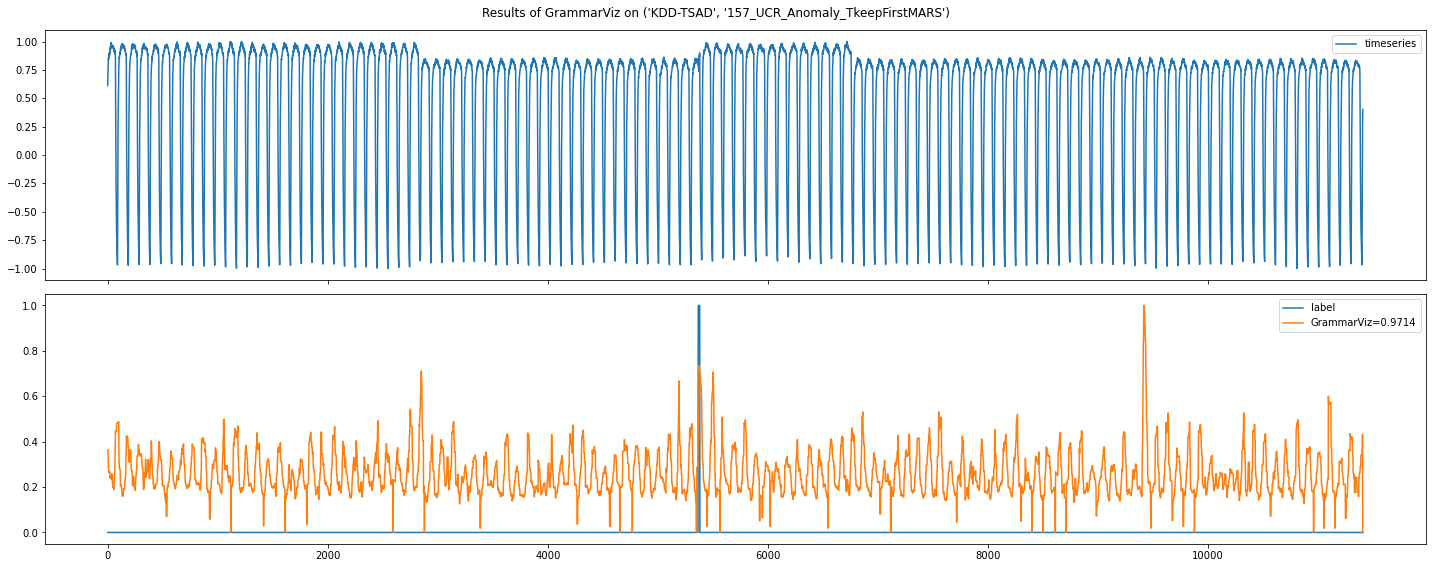

In [45]:
plot_scores("GrammarViz", ("KDD-TSAD", "157_UCR_Anomaly_TkeepFirstMARS"))

#### Most broken datasets

Datasets, for which more than `threshold` (50%) of algorithms failed.

In [46]:
threshold = 0.5
df_dataset_error_counts[df_dataset_error_counts["Status.OK"] < threshold*df_dataset_error_counts["ALL"]]

status                                                                                                 Status.ERROR  \
dataset_training_type dataset_input_dimensionality collection  dataset                                                
SEMI_SUPERVISED       MULTIVARIATE                 Exathlon    1_2_100000_68-16                                  12   
UNSUPERVISED          MULTIVARIATE                 OPPORTUNITY S2-ADL2                                           12   
                                                               S2-ADL3                                           12   
                                                               S3-ADL4                                           12   
                                                               S4-ADL3                                           12   
                                                   LTDB        14149                                             10   
SEMI_SUPERVISED       MULTIVARIATE                 GHL         15_Lev_fault_Temp_corr_seed_49_vars_23             9   
                                                               16_Lev_fault_Temp_corr_seed_53_vars_23             9   
                                                               18_Lev_fault_Temp_corr_seed_59_vars_23             9   
                                                               09_Lev_fault_Temp_corr_seed_37_vars_23             8   
                                                   SMD         machine-1-1                                        8   

status                                                                                                 Status.OK  \
dataset_training_type dataset_input_dimensionality collection  dataset                                             
SEMI_SUPERVISED       MULTIVARIATE                 Exathlon    1_2_100000_68-16                               11   
UNSUPERVISED          MULTIVARIATE                 OPPORTUNITY S2-ADL2                                         2   
                                                               S2-ADL3                                         2   
                                                               S3-ADL4                                         2   
                                                               S4-ADL3                                         2   
                                                   LTDB        14149                                           4   
SEMI_SUPERVISED       MULTIVARIATE                 GHL         15_Lev_fault_Temp_corr_seed_49_vars_23         11   
                                                               16_Lev_fault_Temp_corr_seed_53_vars_23         11   
                                                               18_Lev_fault_Temp_corr_seed_59_vars_23         11   
                                                               09_Lev_fault_Temp_corr_seed_37_vars_23         11   
                                                   SMD         machine-1-1                                    12   

status                                                                                                 Status.TIMEOUT  \
dataset_training_type dataset_input_dimensionality collection  dataset                                                  
SEMI_SUPERVISED       MULTIVARIATE                 Exathlon    1_2_100000_68-16                                     2   
UNSUPERVISED          MULTIVARIATE                 OPPORTUNITY S2-ADL2                                              0   
                                                               S2-ADL3                                              0   
                                                               S3-ADL4                                              0   
                                                               S4-ADL3                                              0   
                                                   LTDB        14149                            

### Dataset quality assessment based on AUC_ROC

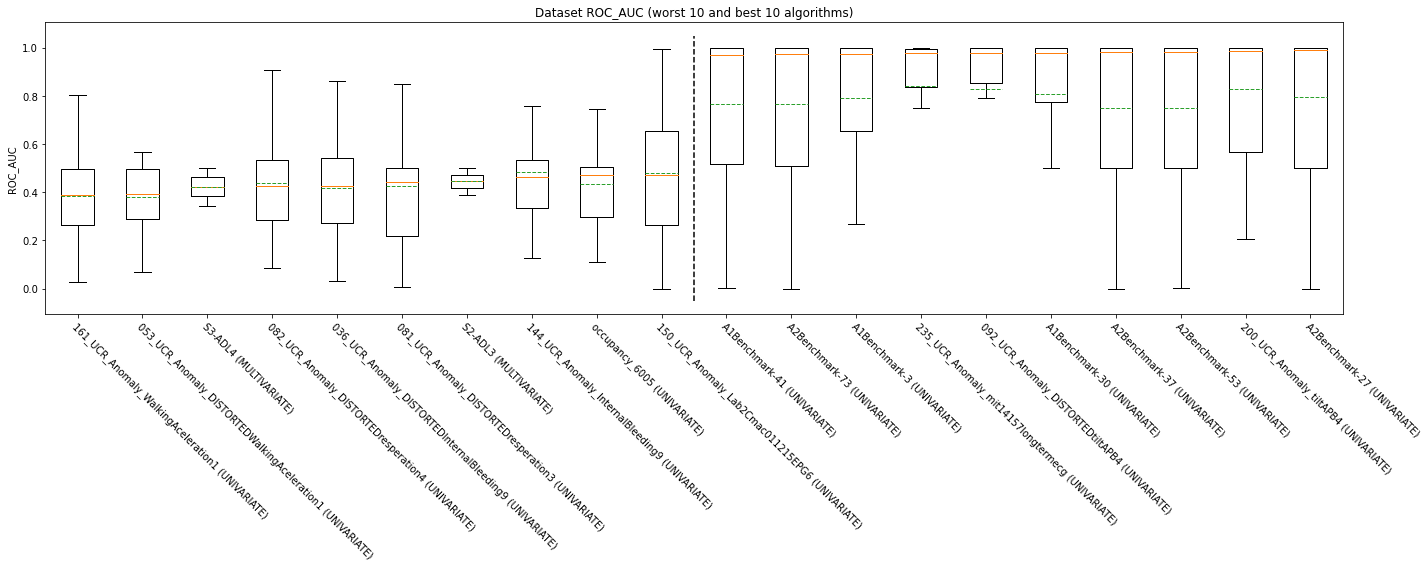

In [47]:
df_datasets = df.pivot(index="dataset", columns="algorithm", values="ROC_AUC")
df_datasets = df_datasets.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_datasets["median"] = df_datasets.median(axis=1)
df_datasets = df_datasets.sort_values(by="median", ascending=True)
df_datasets = df_datasets.drop(columns="median").T

def fmt(x):
    dim = df[(df["dataset"] == x)].iloc[0].loc["dataset_input_dimensionality"]
    return f"{x} ({dim})"

plot_boxplot(df_datasets, n_show = 20, title="Dataset ROC_AUC", ax_label="ROC_AUC", fmt_label=fmt, use_plotly=default_use_plotly)

In [48]:
df_datasets.columns

Index(['161_UCR_Anomaly_WalkingAceleration1',
       '053_UCR_Anomaly_DISTORTEDWalkingAceleration1', 'S3-ADL4',
       '082_UCR_Anomaly_DISTORTEDresperation4',
       '036_UCR_Anomaly_DISTORTEDInternalBleeding9',
       '081_UCR_Anomaly_DISTORTEDresperation3', 'S2-ADL3',
       '144_UCR_Anomaly_InternalBleeding9', 'occupancy_6005',
       '150_UCR_Anomaly_Lab2Cmac011215EPG6',
       ...
       'A1Benchmark-41', 'A2Benchmark-73', 'A1Benchmark-3',
       '235_UCR_Anomaly_mit14157longtermecg',
       '092_UCR_Anomaly_DISTORTEDtiltAPB4', 'A1Benchmark-30', 'A2Benchmark-37',
       'A2Benchmark-53', '200_UCR_Anomaly_tiltAPB4', 'A2Benchmark-27'],
      dtype='object', name='dataset', length=403)

In [49]:
s = df_datasets.max(axis=0)
pd.DataFrame(s[s<0.8], columns=["max AUROC"])

,max AUROC
dataset,
S3-ADL4,0.500000
S2-ADL3,0.500000
exchange-2_cpc_results,0.718801
rogue_agent_key_updown,0.755967
S4-ADL3,0.500000
102,0.534497
241_UCR_Anomaly_taichidbS0715Master,0.677271
100,0.508402
234,0.510252


/tmp/ipykernel_5881/202798847.py:42: UserWarning: No anomaly scores found! Probably k-Means was not executed on ('MITDB', '100').
  warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_id}.")


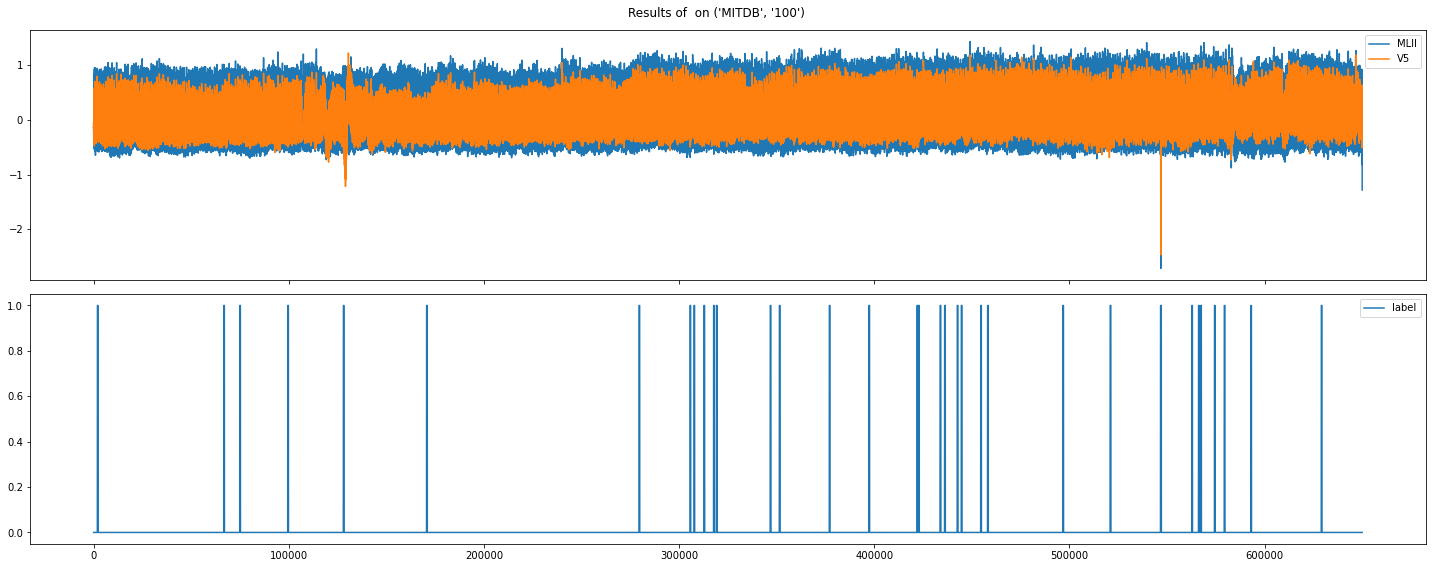

In [50]:
plot_scores("k-Means", ("MITDB", "100"))

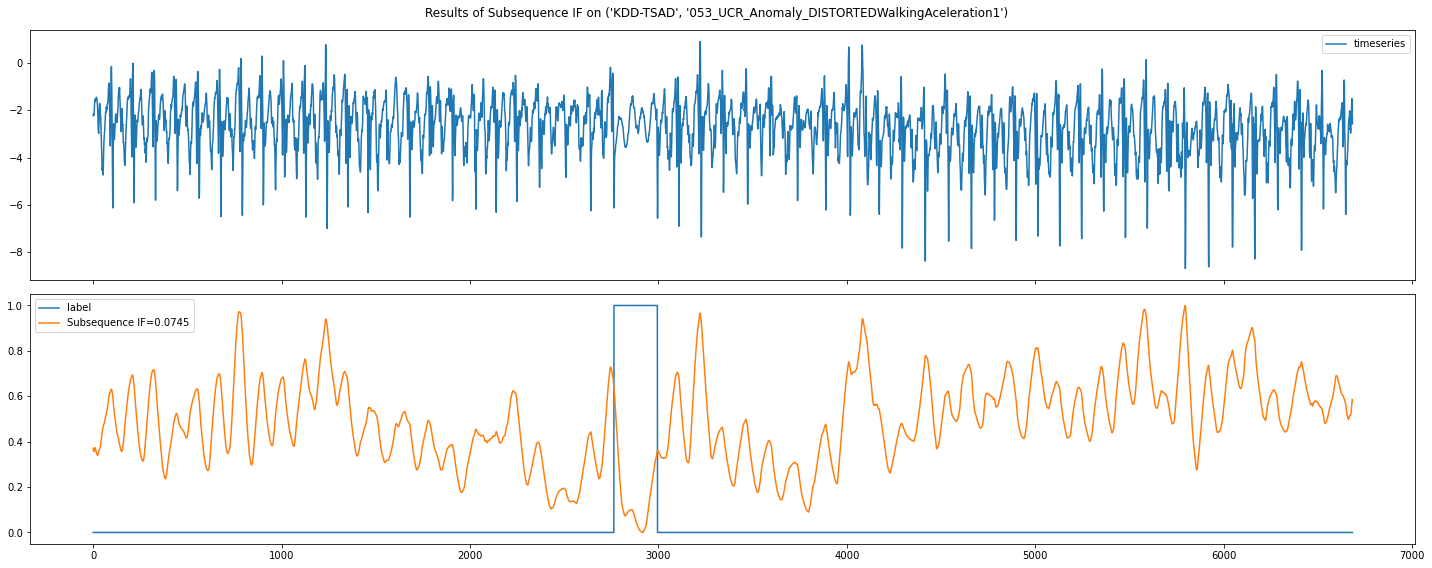

In [51]:
plot_scores("Subsequence IF", ("KDD-TSAD", "053_UCR_Anomaly_DISTORTEDWalkingAceleration1"))

In [52]:
df[(df["algorithm"] == "Subsequence IF") & (df["collection"] == "KDD-TSAD") & (df["dataset"] == "053_UCR_Anomaly_DISTORTEDWalkingAceleration1")]["hyper_params"].values.item()

'{"bootstrap": true, "max_features": 1.0, "n_jobs": 1, "n_trees": 500, "random_state": 42, "verbose": 0, "window_size": 59}'

### Dataset runtime assessment

## Group Algorithms by Attributes

### Training Type

In [53]:
def filtered(attr: str, value: str) -> pd.Series:
    return df_asl[set(df_asl.columns) & set(df[df[attr] == value].algorithm.unique())].mean(axis=0).sort_values()

def get_filtered_summary(attr: str, value: str) -> pd.DataFrame:
    return pd.DataFrame(filtered(attr, value), columns=["Mean AUC_ROC"]).sort_values("Mean AUC_ROC", ascending=False)

def get_filtered_algorithms(attr: str, value: str) -> pd.DataFrame:
    return df_asl[filtered(attr, value).index]

#### Unsupervised

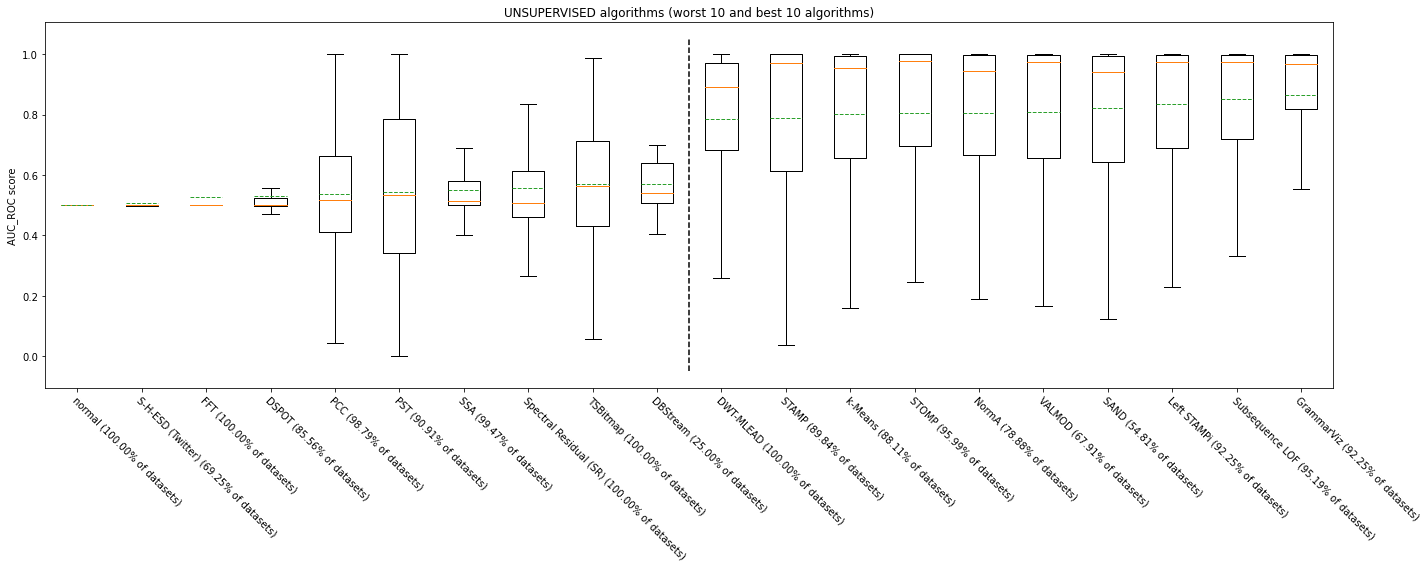

In [54]:
n_show = 20
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({dataset_count_lut[c]:6.2%} of datasets)"

plot_boxplot(get_filtered_algorithms("algo_training_type", "UNSUPERVISED"), title="UNSUPERVISED algorithms", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show)

In [55]:
get_filtered_summary("algo_training_type", "UNSUPERVISED")

,Mean AUC_ROC
algorithm,
GrammarViz,0.863841
Subsequence LOF,0.851512
Left STAMPi,0.834977
SAND,0.820575
VALMOD,0.808344
NormA,0.804906
STOMP,0.803718
k-Means,0.800783
STAMP,0.788226


#### Semi-Supervised

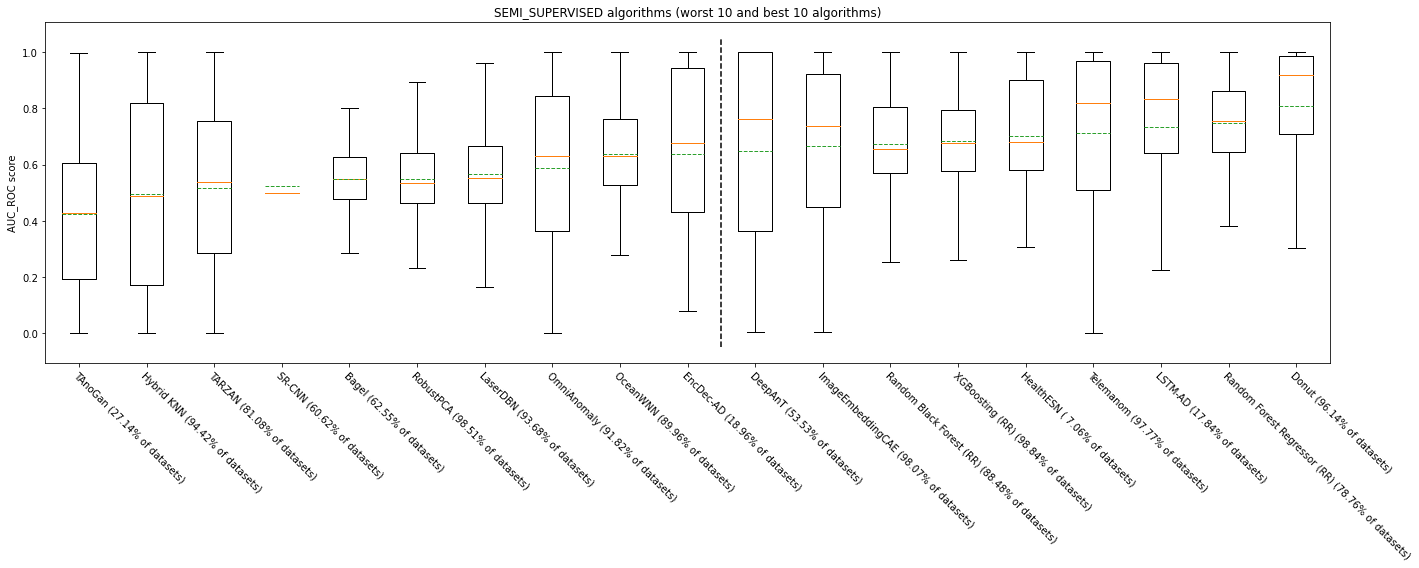

In [56]:
n_show = 20
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({dataset_count_lut[c]:6.2%} of datasets)"

plot_boxplot(get_filtered_algorithms("algo_training_type", "SEMI_SUPERVISED"), title="SEMI_SUPERVISED algorithms", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show)

In [57]:
get_filtered_summary("algo_training_type", "SEMI_SUPERVISED")

,Mean AUC_ROC
algorithm,
Donut,0.808930
Random Forest Regressor (RR),0.748202
LSTM-AD,0.734644
Telemanom,0.711975
HealthESN,0.701975
XGBoosting (RR),0.684429
Random Black Forest (RR),0.672885
ImageEmbeddingCAE,0.666099
DeepAnT,0.646330


#### Supervised

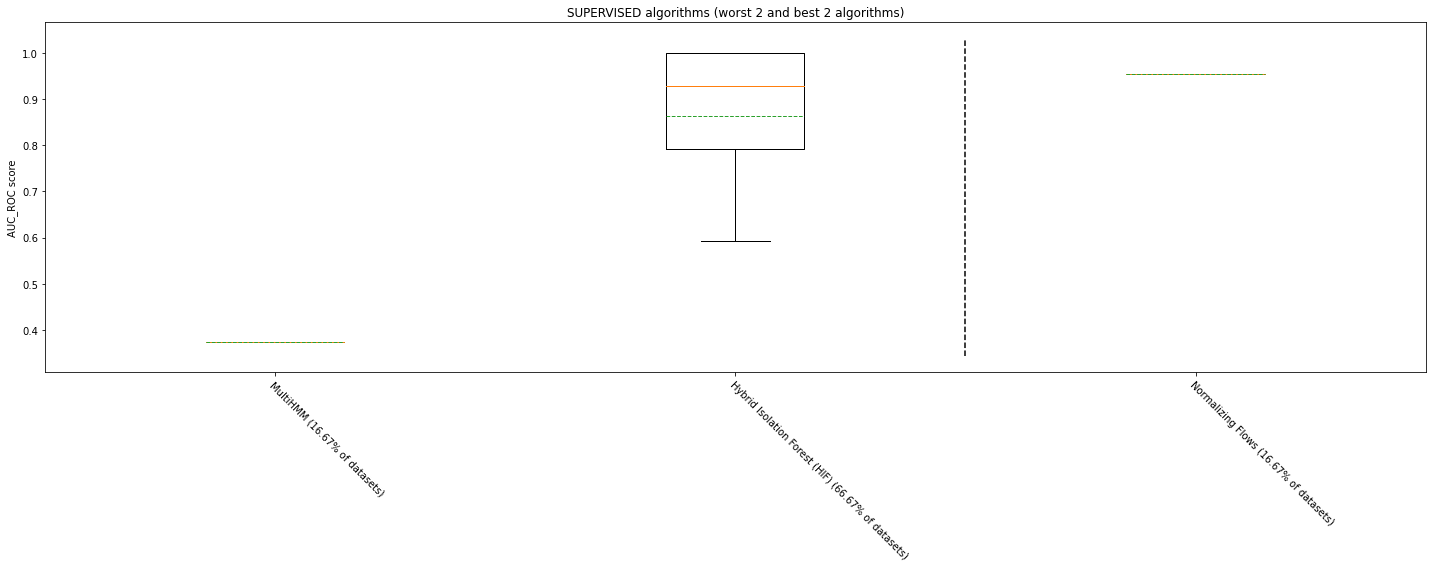

In [58]:
n_show = 4
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({dataset_count_lut[c]:6.2%} of datasets)"

plot_boxplot(get_filtered_algorithms("algo_training_type", "SUPERVISED"), title="SUPERVISED algorithms", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show)

In [59]:
get_filtered_summary("algo_training_type", "SUPERVISED")

,Mean AUC_ROC
algorithm,
Normalizing Flows,0.952979
Hybrid Isolation Forest (HIF),0.862163
MultiHMM,0.374354


### Input Dimensionality

#### Univariate

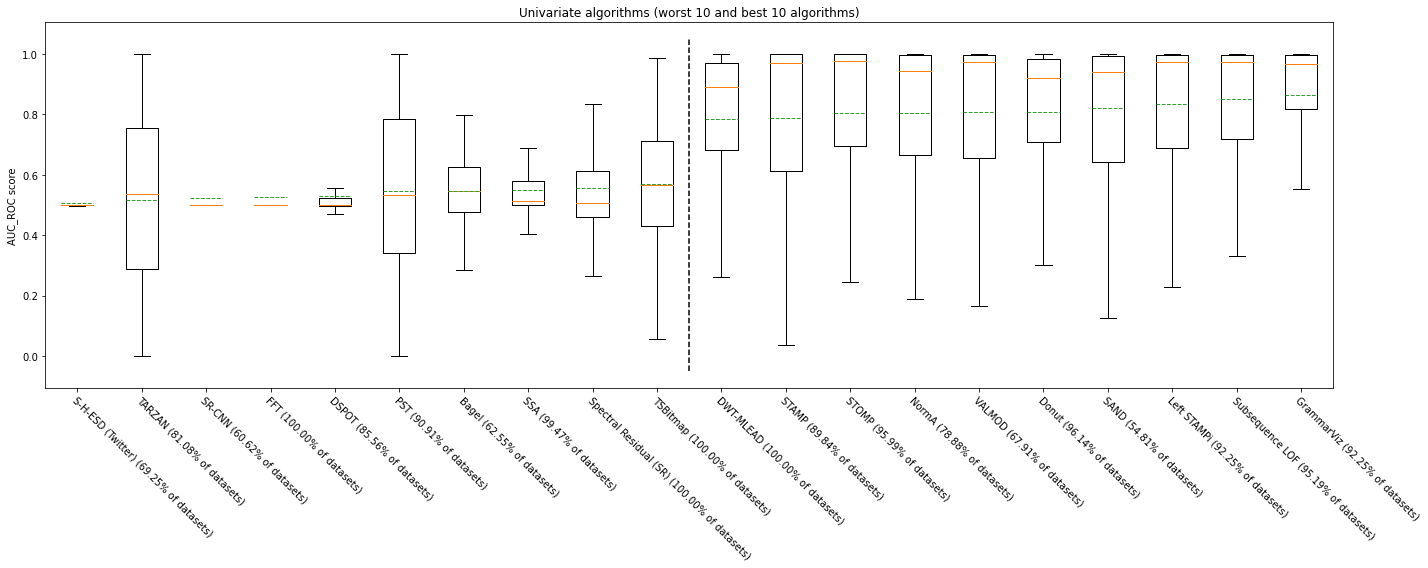

In [60]:
n_show = 20
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({dataset_count_lut[c]:6.2%} of datasets)"

plot_boxplot(get_filtered_algorithms("algo_input_dimensionality", "UNIVARIATE"), title="Univariate algorithms", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show)

In [61]:
get_filtered_summary("algo_input_dimensionality", "UNIVARIATE")

,Mean AUC_ROC
algorithm,
GrammarViz,0.863841
Subsequence LOF,0.851512
Left STAMPi,0.834977
SAND,0.820575
Donut,0.808930
VALMOD,0.808344
NormA,0.804906
STOMP,0.803718
STAMP,0.788226


#### Multivariate

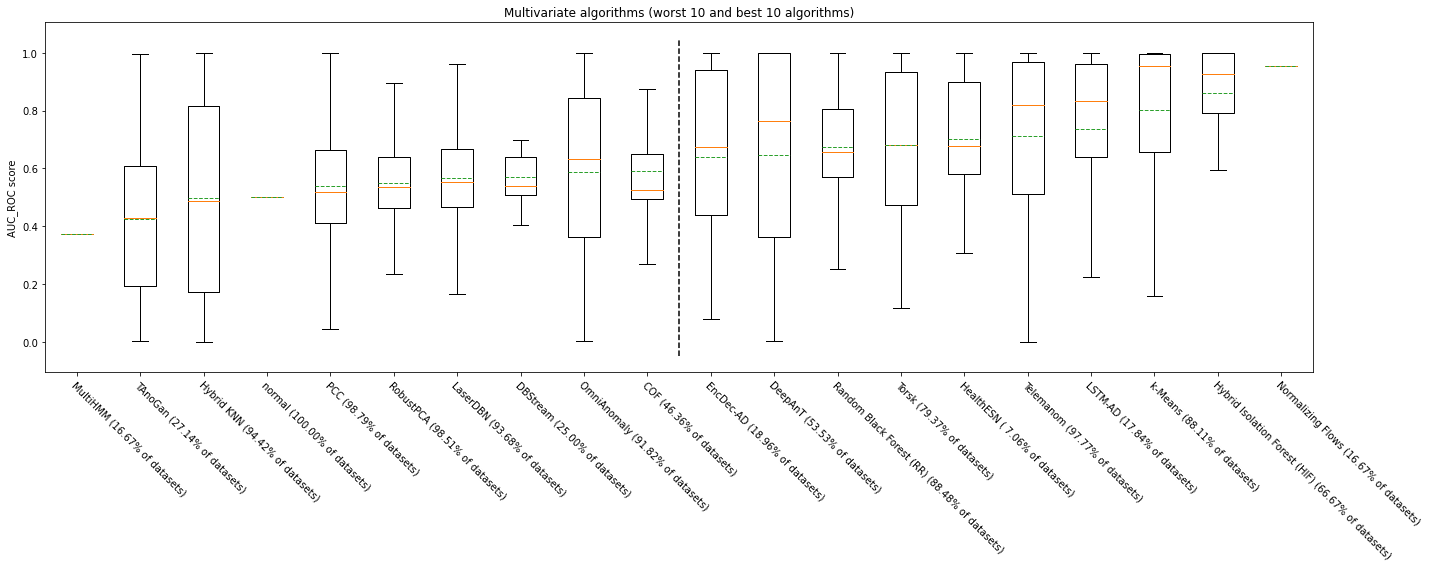

In [62]:
n_show = 20
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({dataset_count_lut[c]:6.2%} of datasets)"

plot_boxplot(get_filtered_algorithms("algo_input_dimensionality", "MULTIVARIATE"), title="Multivariate algorithms", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show)

In [63]:
get_filtered_summary("algo_input_dimensionality", "MULTIVARIATE")

,Mean AUC_ROC
algorithm,
Normalizing Flows,0.952979
Hybrid Isolation Forest (HIF),0.862163
k-Means,0.800783
LSTM-AD,0.734644
Telemanom,0.711975
HealthESN,0.701975
Torsk,0.680297
Random Black Forest (RR),0.672885
DeepAnT,0.646330


## Other insights

- draw a critical difference diagram (cd-diagram) using Wilcoxon-Holm tests: https://github.com/hfawaz/cd-diagram
- algorithms that get good results, but run into timeouts often